In [1]:
# Generalized Additive Models and Trees and Boosting

In [2]:
import collections

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from pymatgen.core import Composition

rcparams = {'legend.fontsize': 20,
            'figure.figsize': (12, 8),
            'axes.labelsize': 24,
            'axes.titlesize': 28,
            'xtick.labelsize':20,
            'ytick.labelsize': 20}
sns.set(rc=rcparams)
mpl.rcParams.update(rcparams)

%matplotlib inline
%config InlineBackend.figure_format ='retina'

from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, \
    GradientBoostingClassifier, GradientBoostingRegressor, \
    RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import export_text, export_graphviz

from statsmodels.gam.generalized_additive_model import GLMGam
from statsmodels.gam.api import BSplines
import statsmodels.api as sm

In [3]:
# by default pandas will recognize NaN (sodium nitride) as nan (not a number)
# to turn off this behavior, we use na_filter=False
data = pd.read_csv("data.csv", index_col=0, na_filter=False)

# Let's create a column of Composition objects using pymatgen.
data["composition"] = [Composition(f) for f in data["formula"]]

In [4]:
el_data = pd.read_csv("element_properties.csv", index_col=0)
el_data = el_data[['AtomicRadius', 'AtomicWeight', 'Column', 'Electronegativity', 'Row']]

In [5]:
props = collections.defaultdict(list)


for comp in data["composition"]:
    for c in el_data.columns:
        vals = [el_data[c][el.symbol] * amt for el, amt in comp.items()]
        props["%sMean" % c].append(sum(vals)/ comp.num_atoms)
        props["%sMin" % c].append(min(vals))
        props["%sMax" % c].append(max(vals))
data = data.assign(**props)
data = data.dropna()
print(data.shape)

(124342, 21)


In [6]:
features = [c for c in data.columns if c.endswith("Mean") or c.endswith("Min") or c.endswith("Max")]
x = data[features]
y_class = [0 if bg < 1e-4 else 1 for bg in data["band_gap"]]
y_reg = data["band_gap"]

In [8]:
def plot_grid_search_results(gs, ylim=None):
    """
    Plots the results of GridSearchCV.
    
    Args:
        gs: A GridSearchCV object.
        ylim: Optional setting for y limits.
    """
    results = pd.DataFrame(gs.cv_results_)
    for c in results.columns:
        # Note that here we are working with just variations in one parameter.
        # So we can automatically find the name of that parameter.
        if c.startswith("param_"):
            x = c
            break
    fig, ax = plt.subplots(figsize=(16, 8))    
    ax = sns.lineplot(x=x, y="mean_train_score", data=results)
    ax = sns.scatterplot(x=x, y="mean_train_score", data=results, marker='x')
    ax = sns.lineplot(x=x, y="mean_test_score", data=results)
    ax = sns.scatterplot(x=x, y="mean_test_score", data=results, marker='o')
    plt.xlabel(x)
    if ylim:
        plt.ylim(ylim)
    ax.legend(["Train", "Test"], loc=2);
    
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# Generalized Additive Models

In [10]:
# GAM model is difficult to train, here we use a very small train data size 
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.9, random_state=42)

# smoother over the 15 variables, with each variable using 6 basis function (the df parameter)
# and degree of 4 (the degree parameter) splines. 
bs = BSplines(x_train, df=[6] * 15, degree=[4] * 15 )

In [11]:
# Create the training data frame, which contains the features and the target, i.e., is_metal
combined_xy = x_train.copy()
combined_xy = combined_xy.assign(**{'is_metal': y_train})

In [12]:
# Gaussian family with Logit link function

binomial = sm.families.Binomial(sm.families.links.logit())
gam_bs = GLMGam.from_formula('is_metal ~ 1', data=combined_xy, smoother=bs, family=binomial)

In [13]:
%time res_bs = gam_bs.fit()

Wall time: 3.15 s


C:\Users\YoYo\miniconda3\envs\nano281\lib\site-packages\statsmodels\genmod\families\links.py:246: RuntimeWarning: divide by zero encountered in true_divide
  return (2*p - 1) / v**2
C:\Users\YoYo\miniconda3\envs\nano281\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:566: RuntimeWarning: invalid value encountered in multiply
  tmp = score_factor * tmp


In [14]:
y_pred_test = []
y_test_valid = []

# some test x is outside the training x bounds, which will cause errors, 
# we use try... except to ignore this error
for x_test_temp, y_test_temp in zip(x_test.values, y_test):
    try:
        transformed = bs.transform(x_test_temp.reshape((1, -1)))
        transformed = np.concatenate([np.array([[1]]), transformed], axis=1)  # add intercept
        y_pred_test.append(gam_bs.predict(res_bs.params, transformed).item())
        y_test_valid.append(y_test_temp)
    except:
        pass

print((f"The prediction accuracy on {len(y_test_valid)} test data is "
       f"{accuracy_score(np.array(y_pred_test)>=0.5, y_test_valid):.3f}"))

The prediction accuracy on 111768 test data is 0.780


In [15]:
# Decision tree classifier

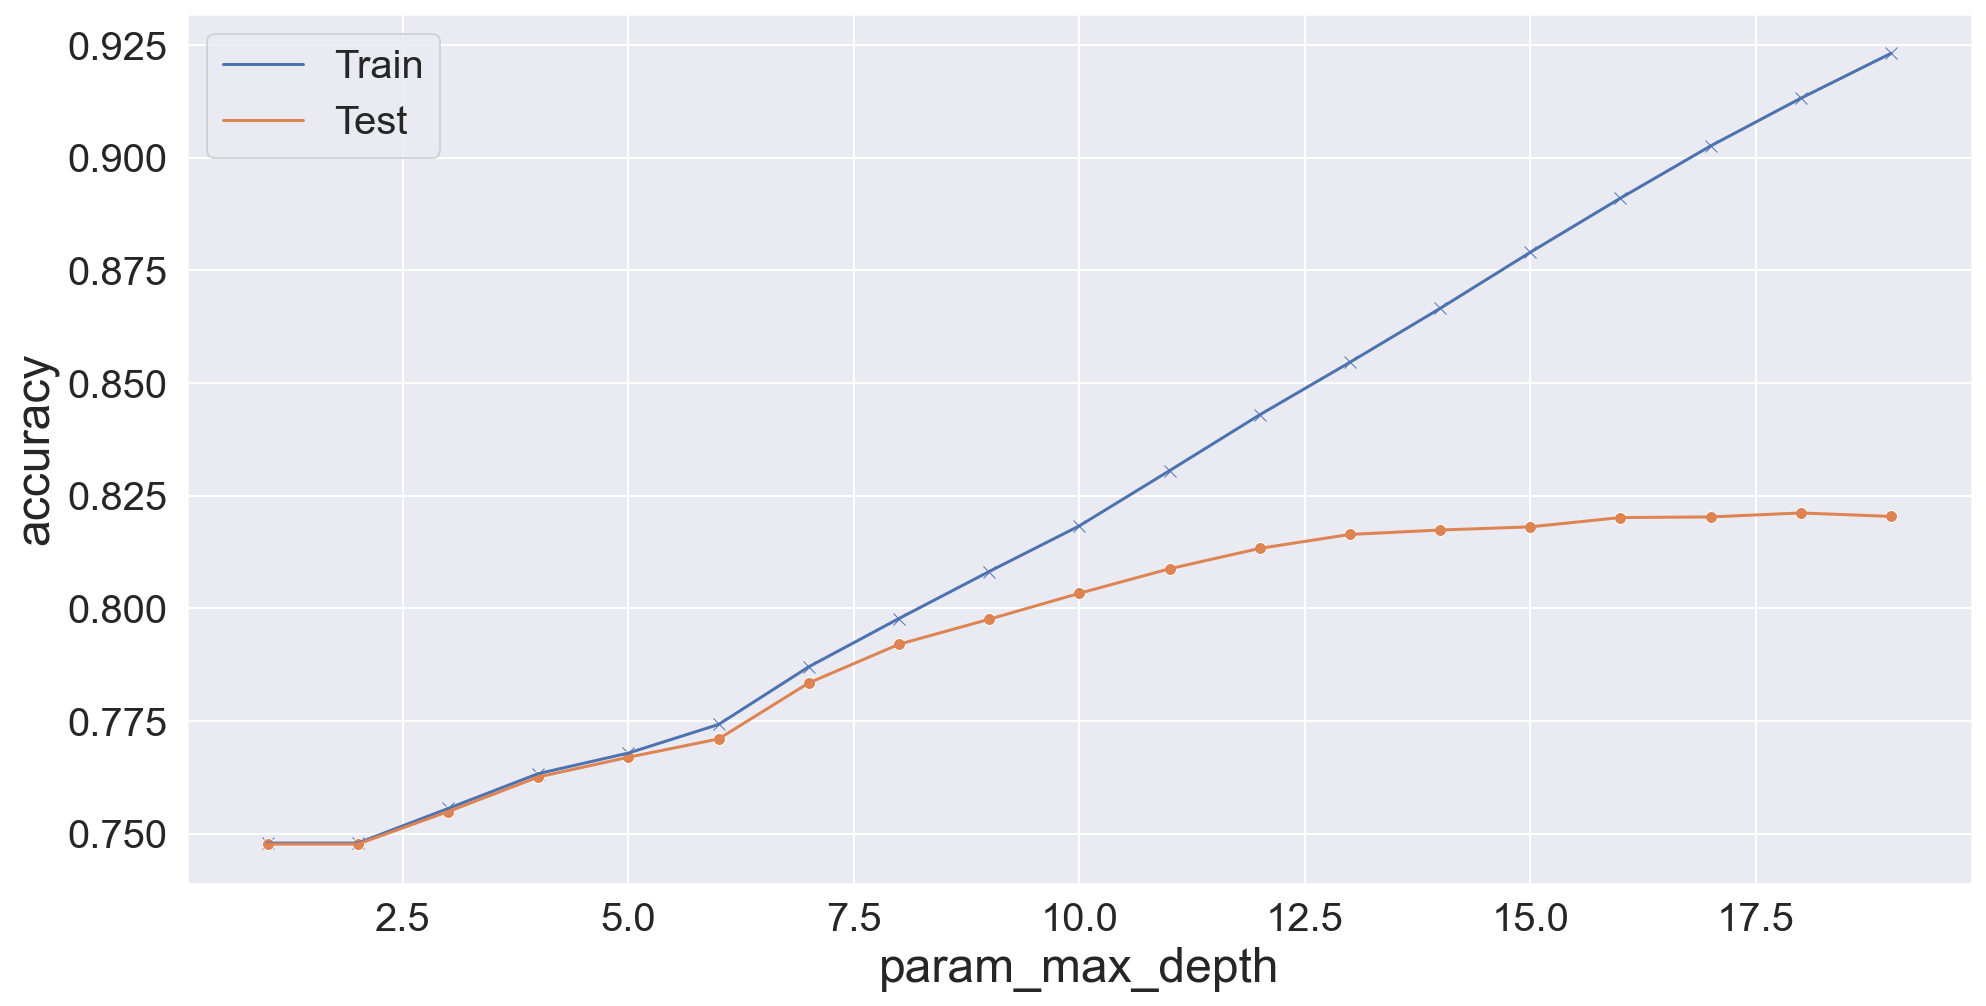

In [16]:
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid={"max_depth": list(range(1, 20))},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy");

In [17]:
gs.cv_results_

{'mean_fit_time': array([0.09501801, 0.15806937, 0.21098919, 0.26936016, 0.32418952,
        0.38507228, 0.4383502 , 0.48960037, 0.55670581, 0.59778857,
        0.68749228, 0.71130342, 0.73336682, 0.72461958, 0.75429173,
        0.78707108, 0.84150953, 0.83997054, 0.86511803]),
 'std_fit_time': array([0.00378447, 0.00458933, 0.00292534, 0.00237504, 0.0023998 ,
        0.00401943, 0.00364046, 0.00098101, 0.01188252, 0.00202866,
        0.03814597, 0.03406902, 0.02897007, 0.00739374, 0.0066112 ,
        0.01115699, 0.03948206, 0.00754444, 0.00865828]),
 'mean_score_time': array([0.00899844, 0.00837169, 0.00877318, 0.00946722, 0.00856071,
        0.00865955, 0.00934038, 0.00917363, 0.00915174, 0.00976205,
        0.0104682 , 0.00996733, 0.01012659, 0.00997334, 0.01037235,
        0.01078753, 0.01055651, 0.01106801, 0.0109755 ]),
 'std_score_time': array([9.34147474e-04, 1.01038728e-03, 7.35122723e-04, 1.14669287e-03,
        1.20548800e-03, 5.15697599e-04, 1.06552449e-03, 3.98340041e-04,


In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2)

decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=8)
decision_tree.fit(x_train, y_train)

# We can export this to a graphviz dot file, which can be used to generate a nice plot.
export_graphviz(decision_tree, out_file="metal_insulator_tree.dot", feature_names=list(x.columns))

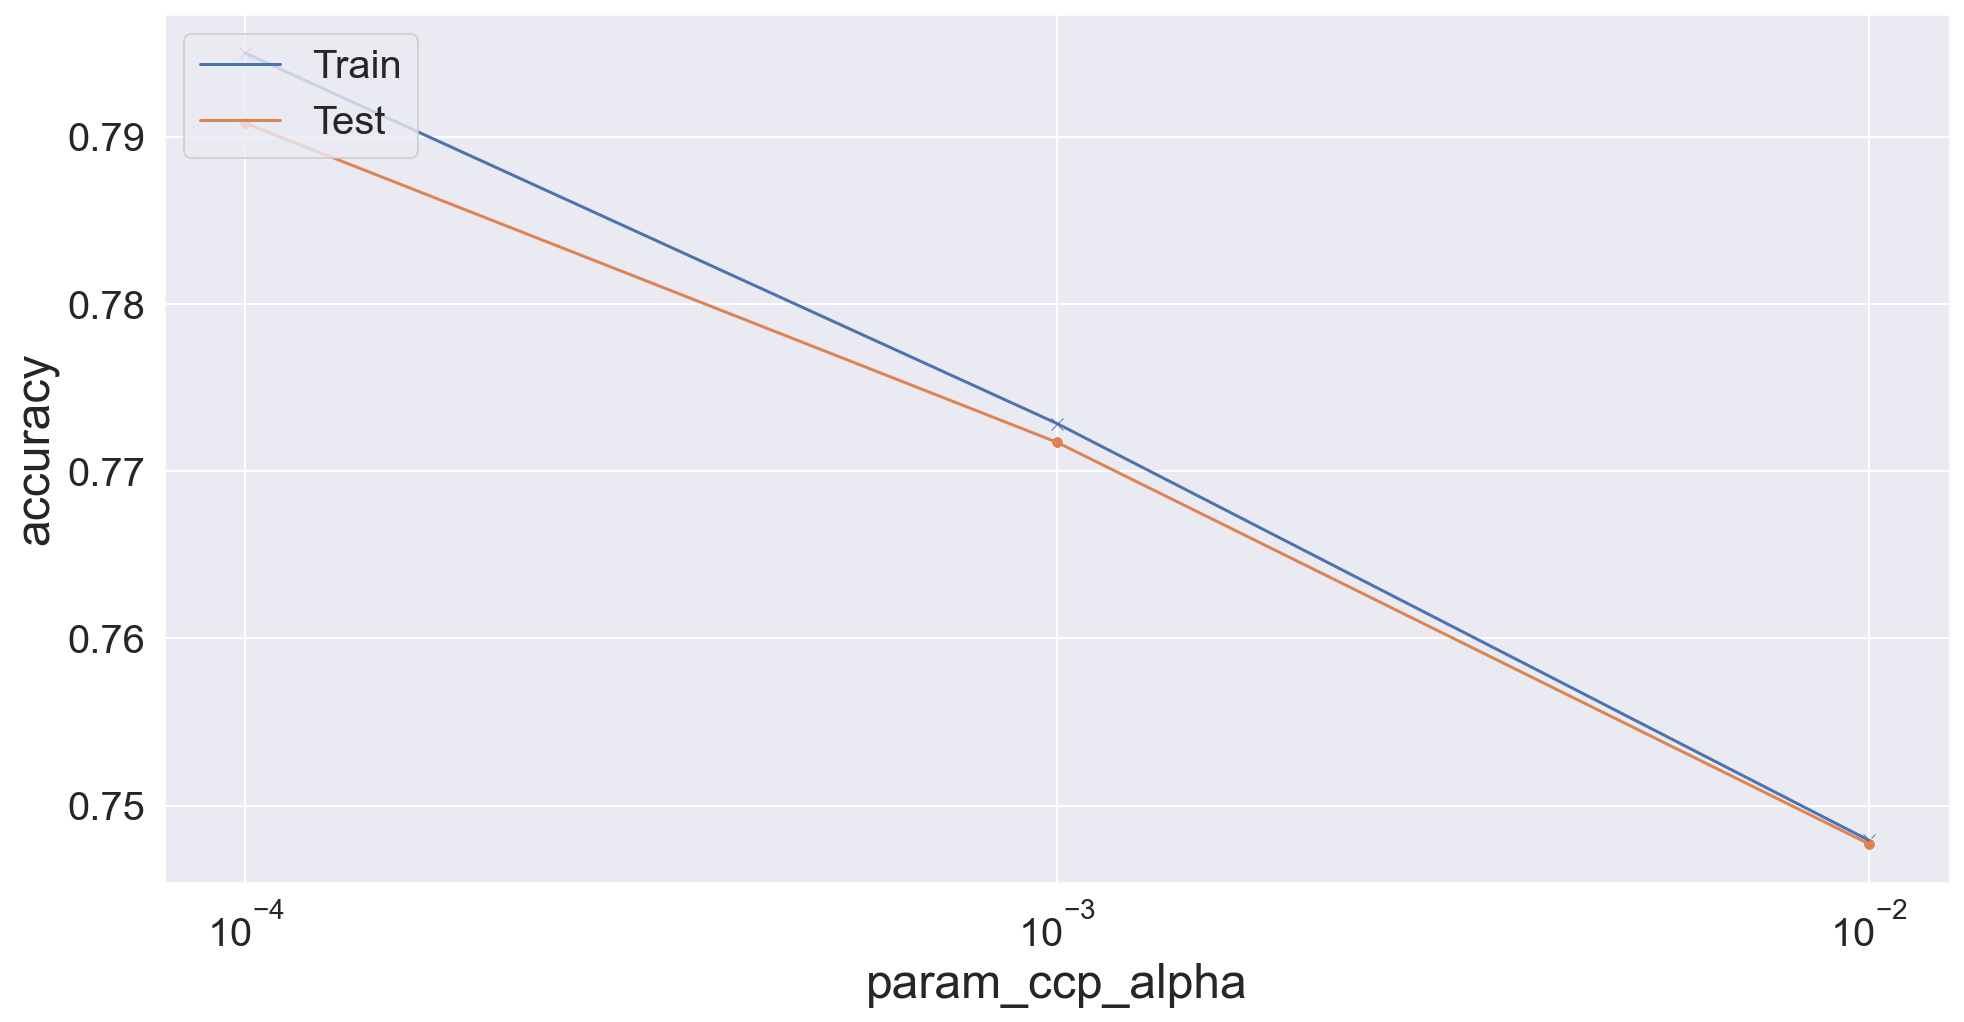

In [19]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=8)
gs = GridSearchCV(
    decision_tree,
    param_grid={"ccp_alpha": [1e-4, 1e-3, 1e-2]},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy")
plt.xscale('log');

In [20]:
decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=3)
decision_tree.fit(x_train, y_train)
r = export_text(decision_tree, feature_names=list(x.columns))
print(r)

|--- ElectronegativityMean <= 2.06
|   |--- ColumnMin <= 2.50
|   |   |--- ElectronegativityMax <= 5.09
|   |   |   |--- class: 0
|   |   |--- ElectronegativityMax >  5.09
|   |   |   |--- class: 1
|   |--- ColumnMin >  2.50
|   |   |--- ColumnMax <= 44.50
|   |   |   |--- class: 0
|   |   |--- ColumnMax >  44.50
|   |   |   |--- class: 0
|--- ElectronegativityMean >  2.06
|   |--- AtomicRadiusMean <= 0.97
|   |   |--- RowMean <= 2.48
|   |   |   |--- class: 1
|   |   |--- RowMean >  2.48
|   |   |   |--- class: 1
|   |--- AtomicRadiusMean >  0.97
|   |   |--- RowMean <= 5.46
|   |   |   |--- class: 1
|   |   |--- RowMean >  5.46
|   |   |   |--- class: 0



In [21]:
# Feature importance

C:\Users\YoYo\miniconda3\envs\nano281\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


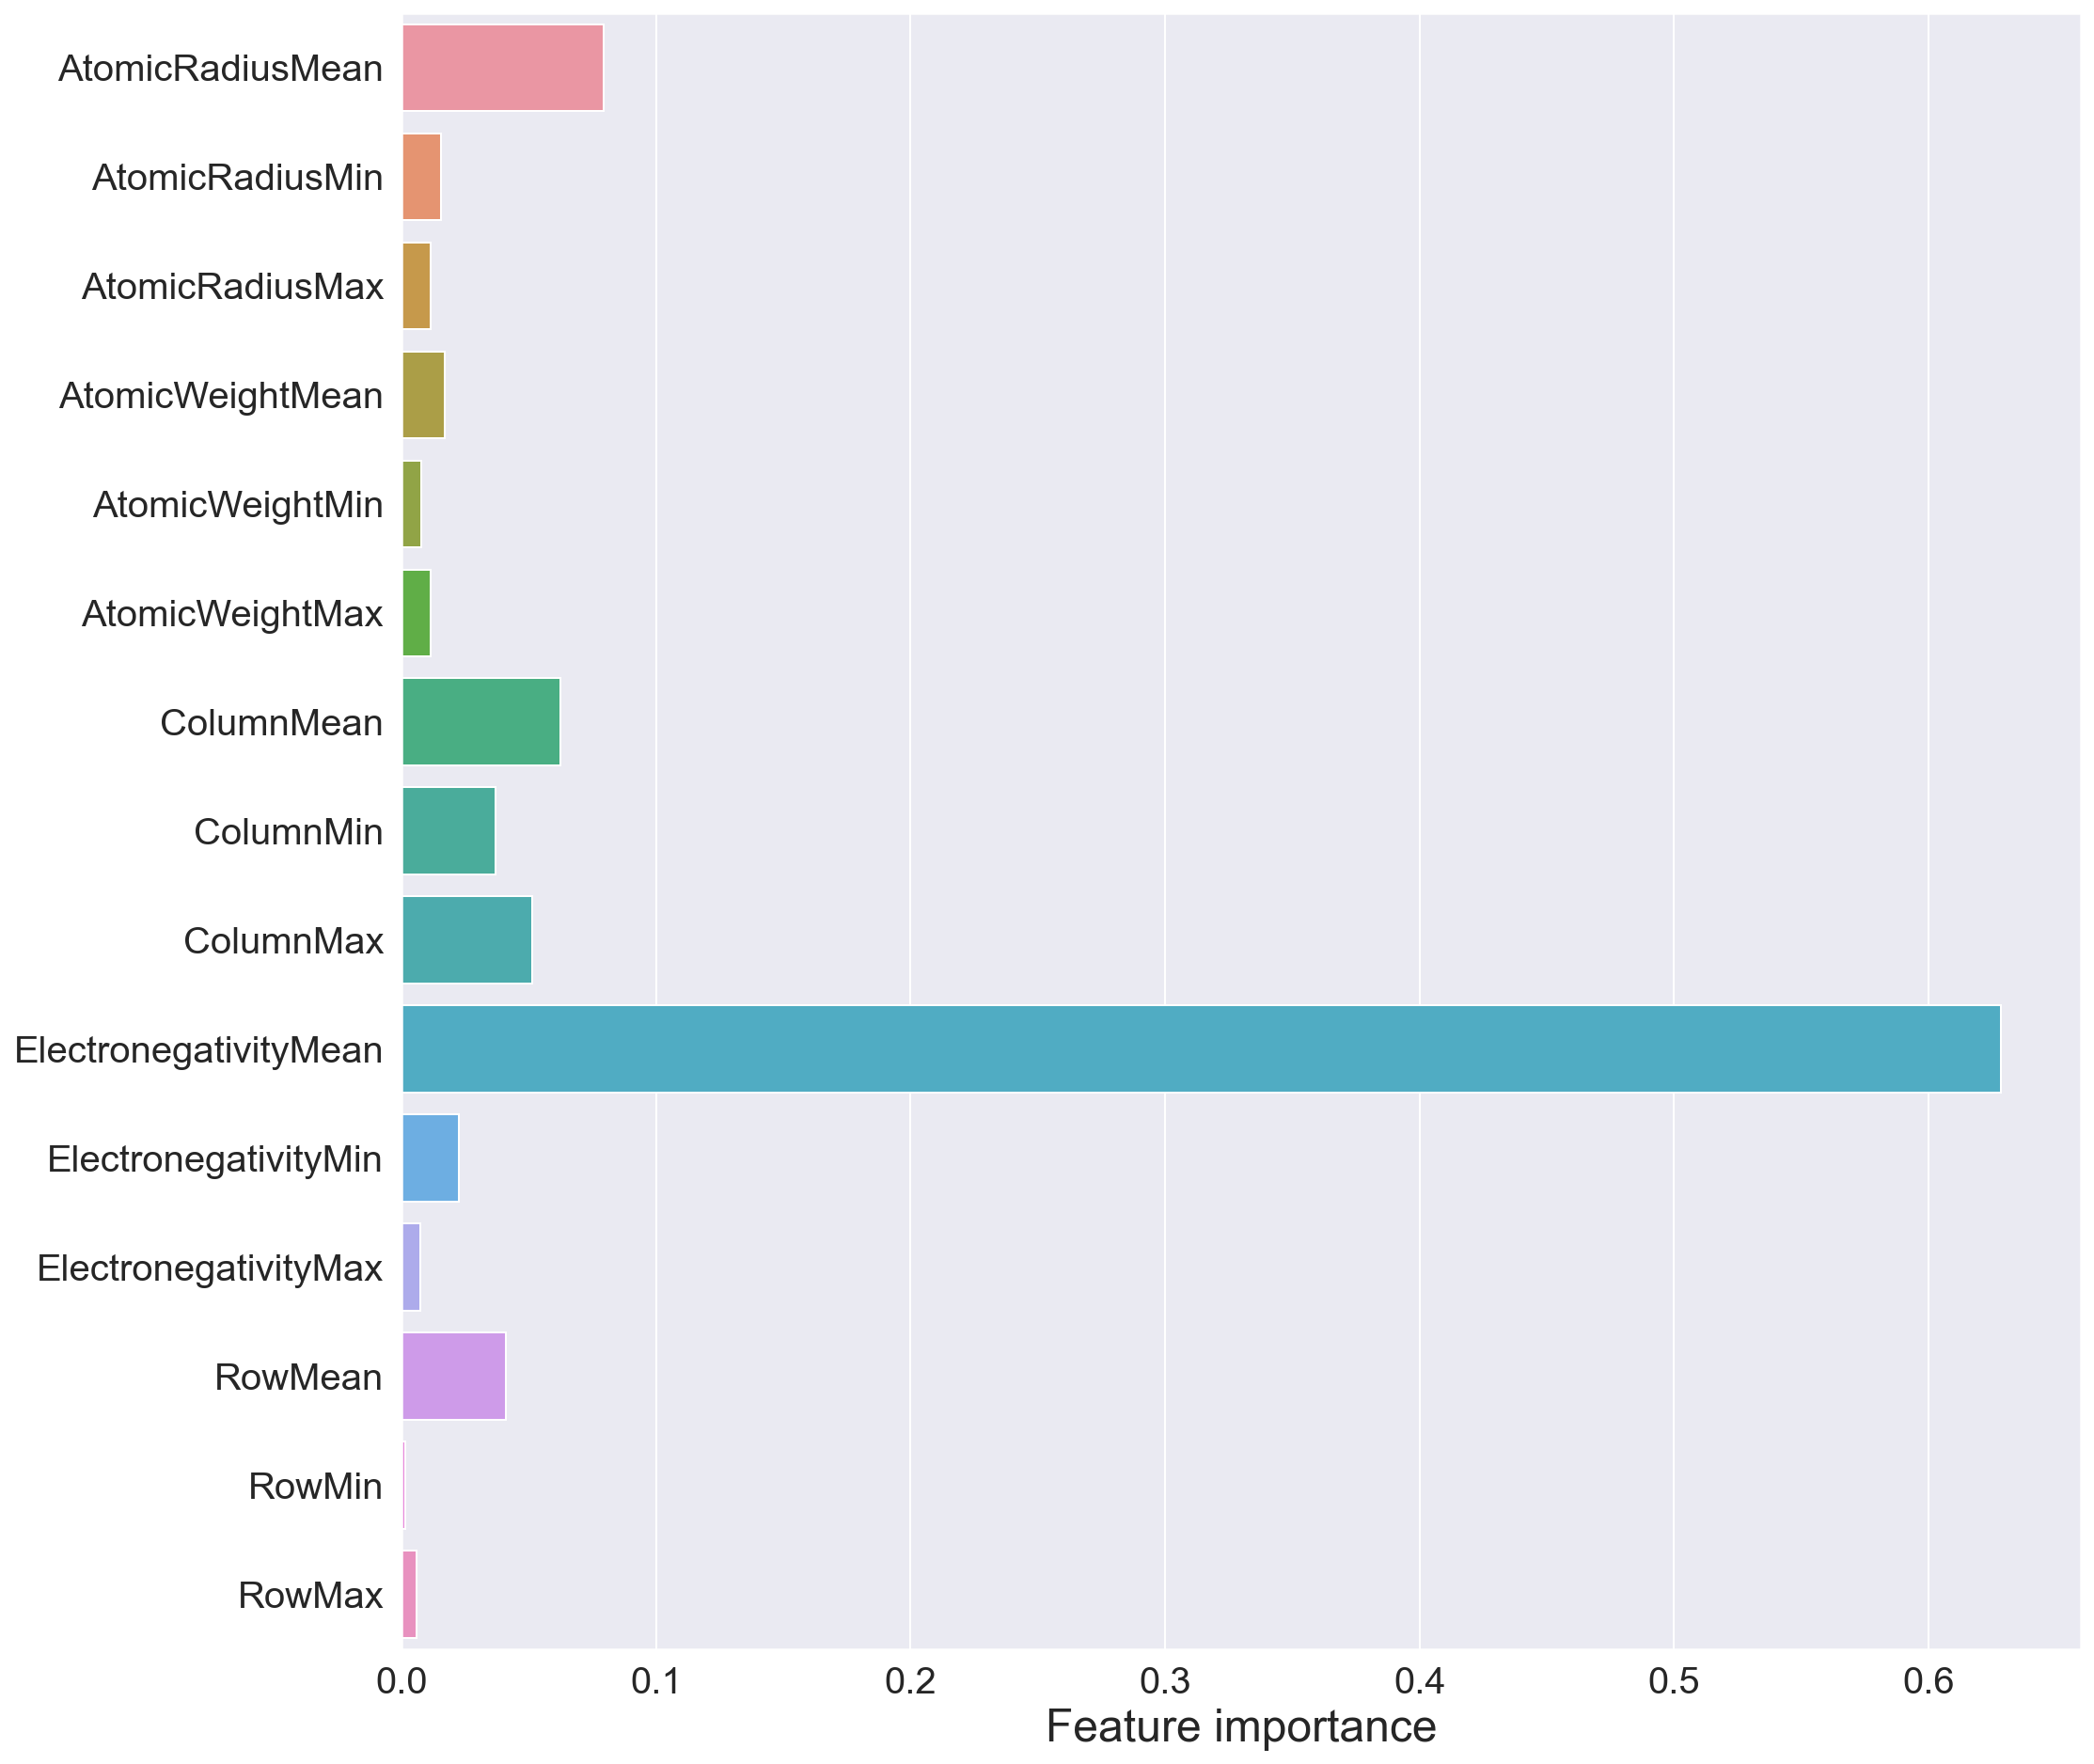

In [22]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=8)
decision_tree.fit(x_train, y_train)
plt.subplots(figsize=(16, 16))
sns.barplot(decision_tree.feature_importances_, list(x.columns), orient='h')
plt.xlabel("Feature importance");

In [23]:
# Receiver Operating Characteristic Curve

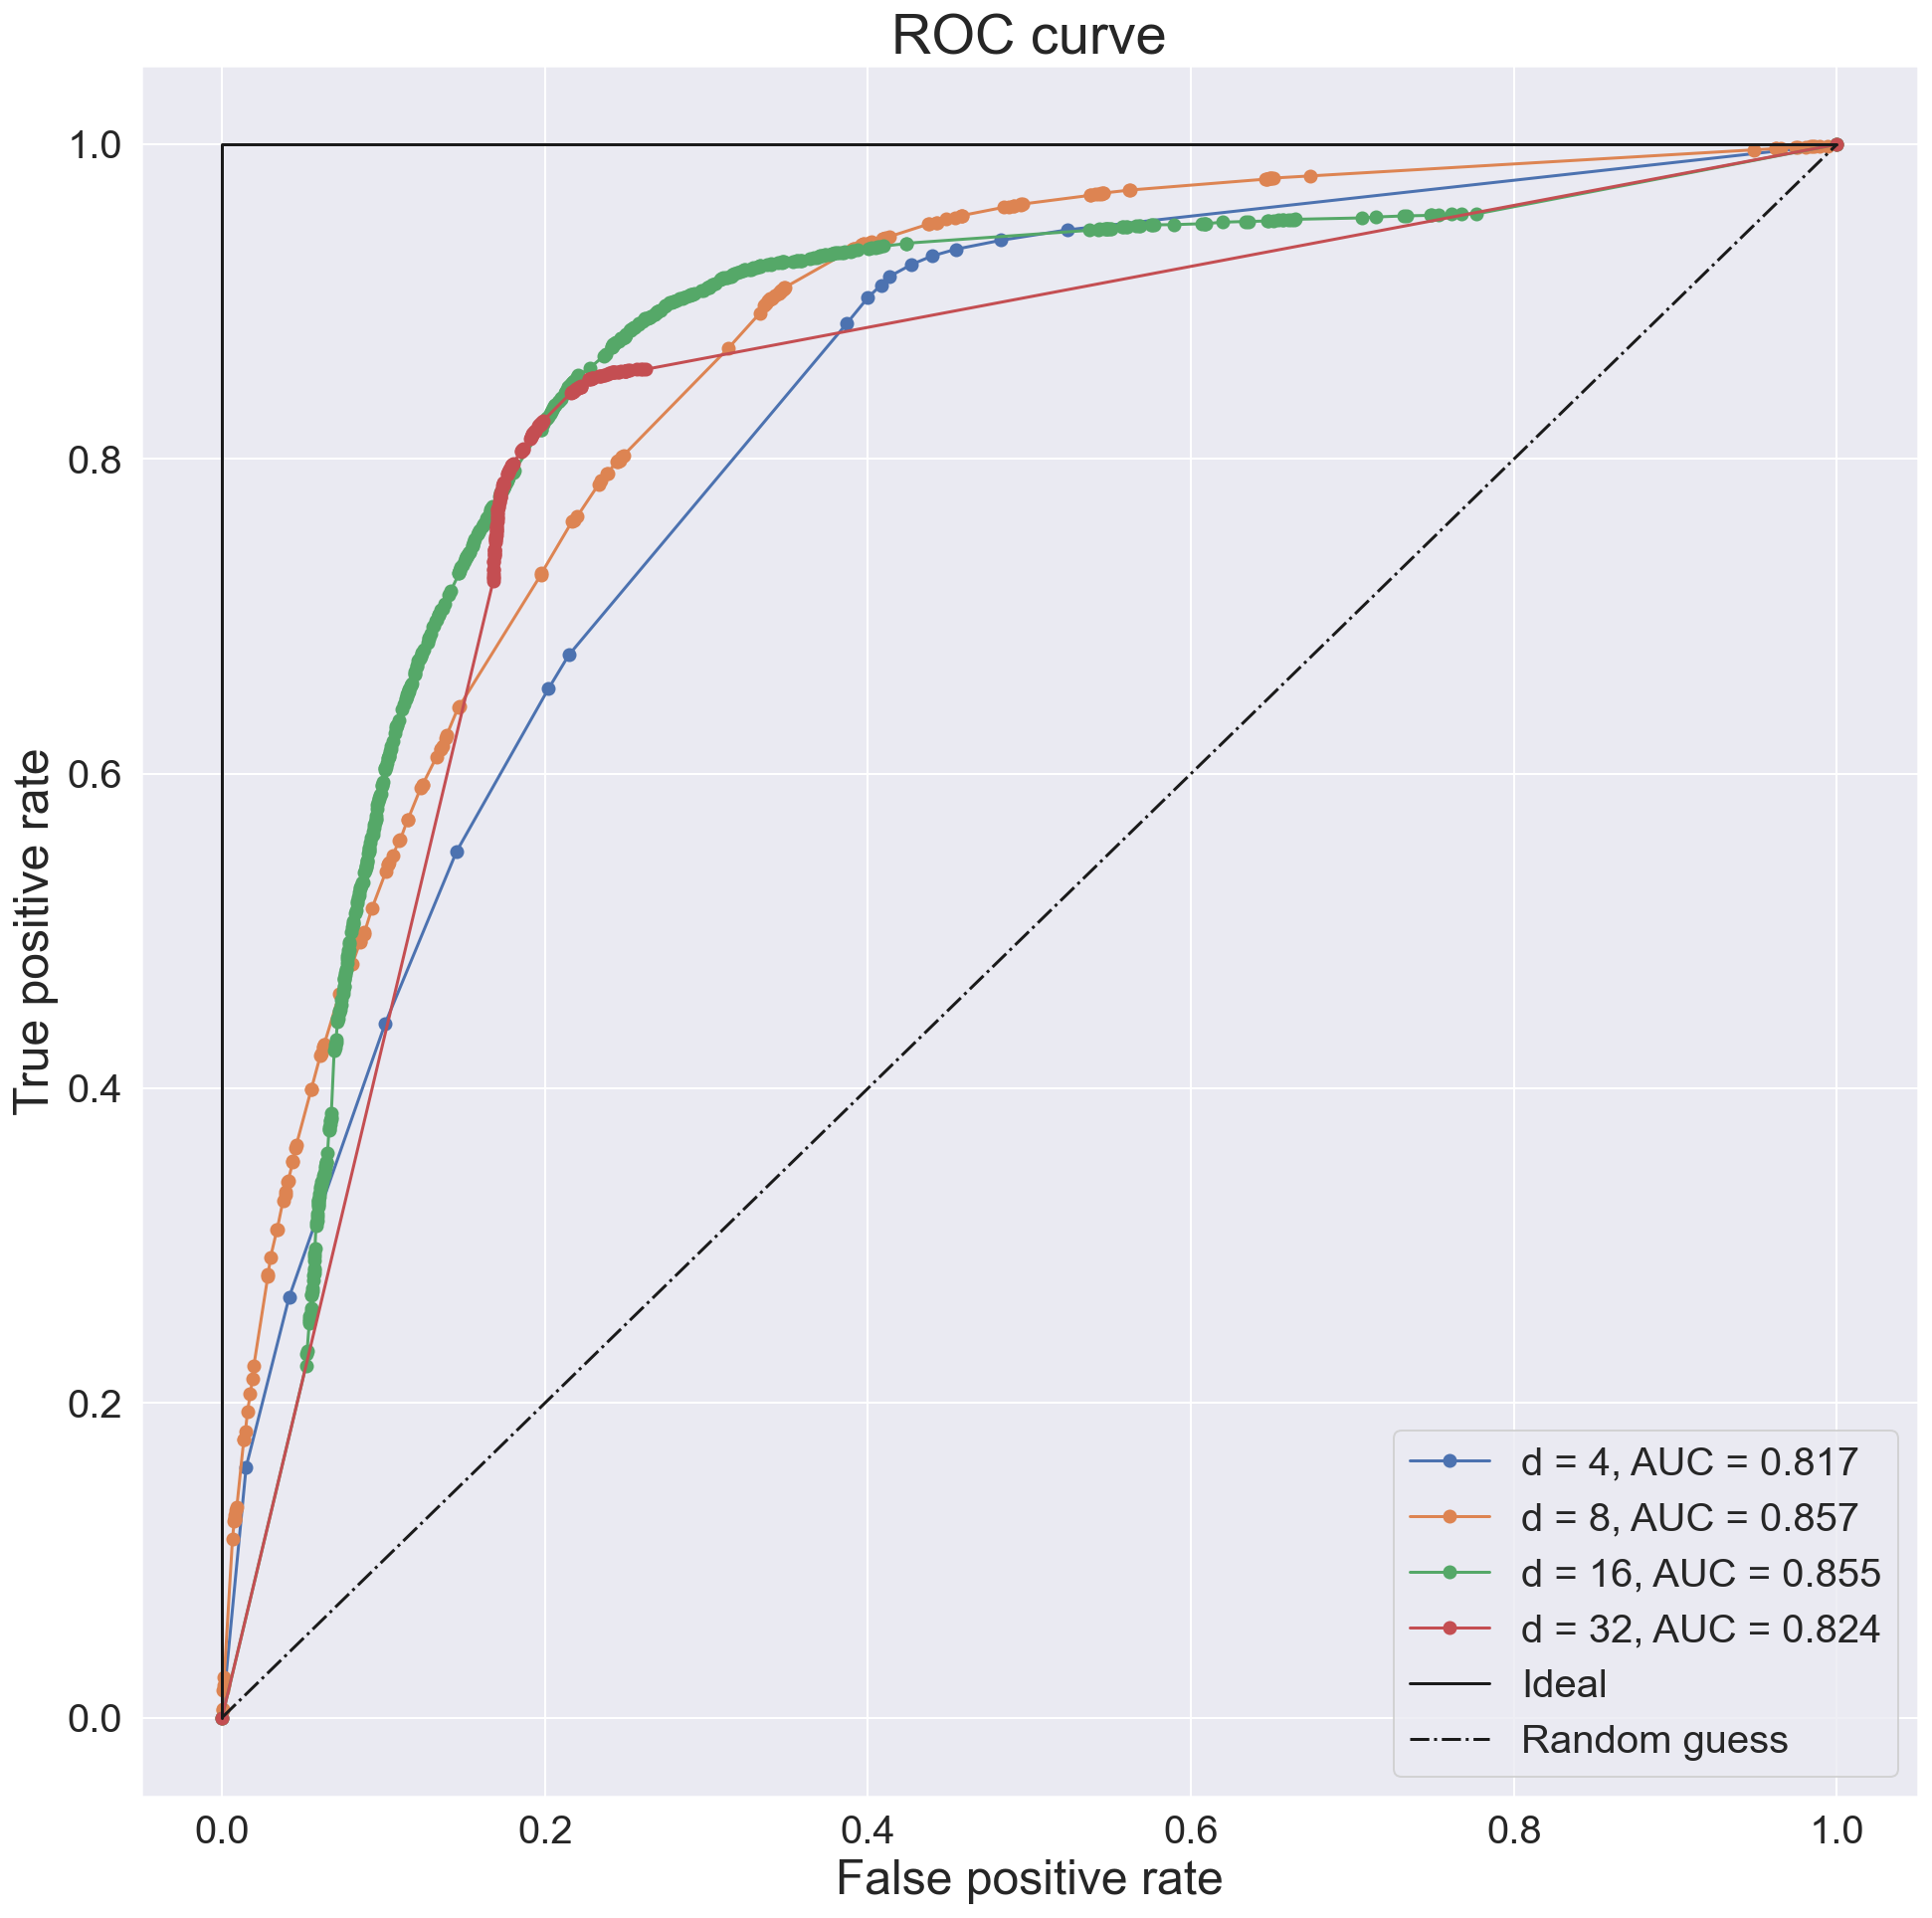

In [24]:
plt.subplots(figsize=(16, 16))
for d in [4, 8, 16, 32]:
    decision_tree = DecisionTreeClassifier(random_state=0, max_depth=d)
    decision_tree = decision_tree.fit(x_train, y_train)
    train_accuracy = decision_tree.score(x_train, y_train)
    test_accuracy = decision_tree.score(x_test, y_test)

    y_pred = decision_tree.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    a = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, 'o-', label='d = %d, AUC = %.3f' % (d, a))

plt.plot([0, 0, 1], [0, 1, 1], 'k-', label="Ideal")
plt.plot([0, 1], [0, 1], 'k-.', label="Random guess")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best');

In [25]:
# Decision Tree Regressor

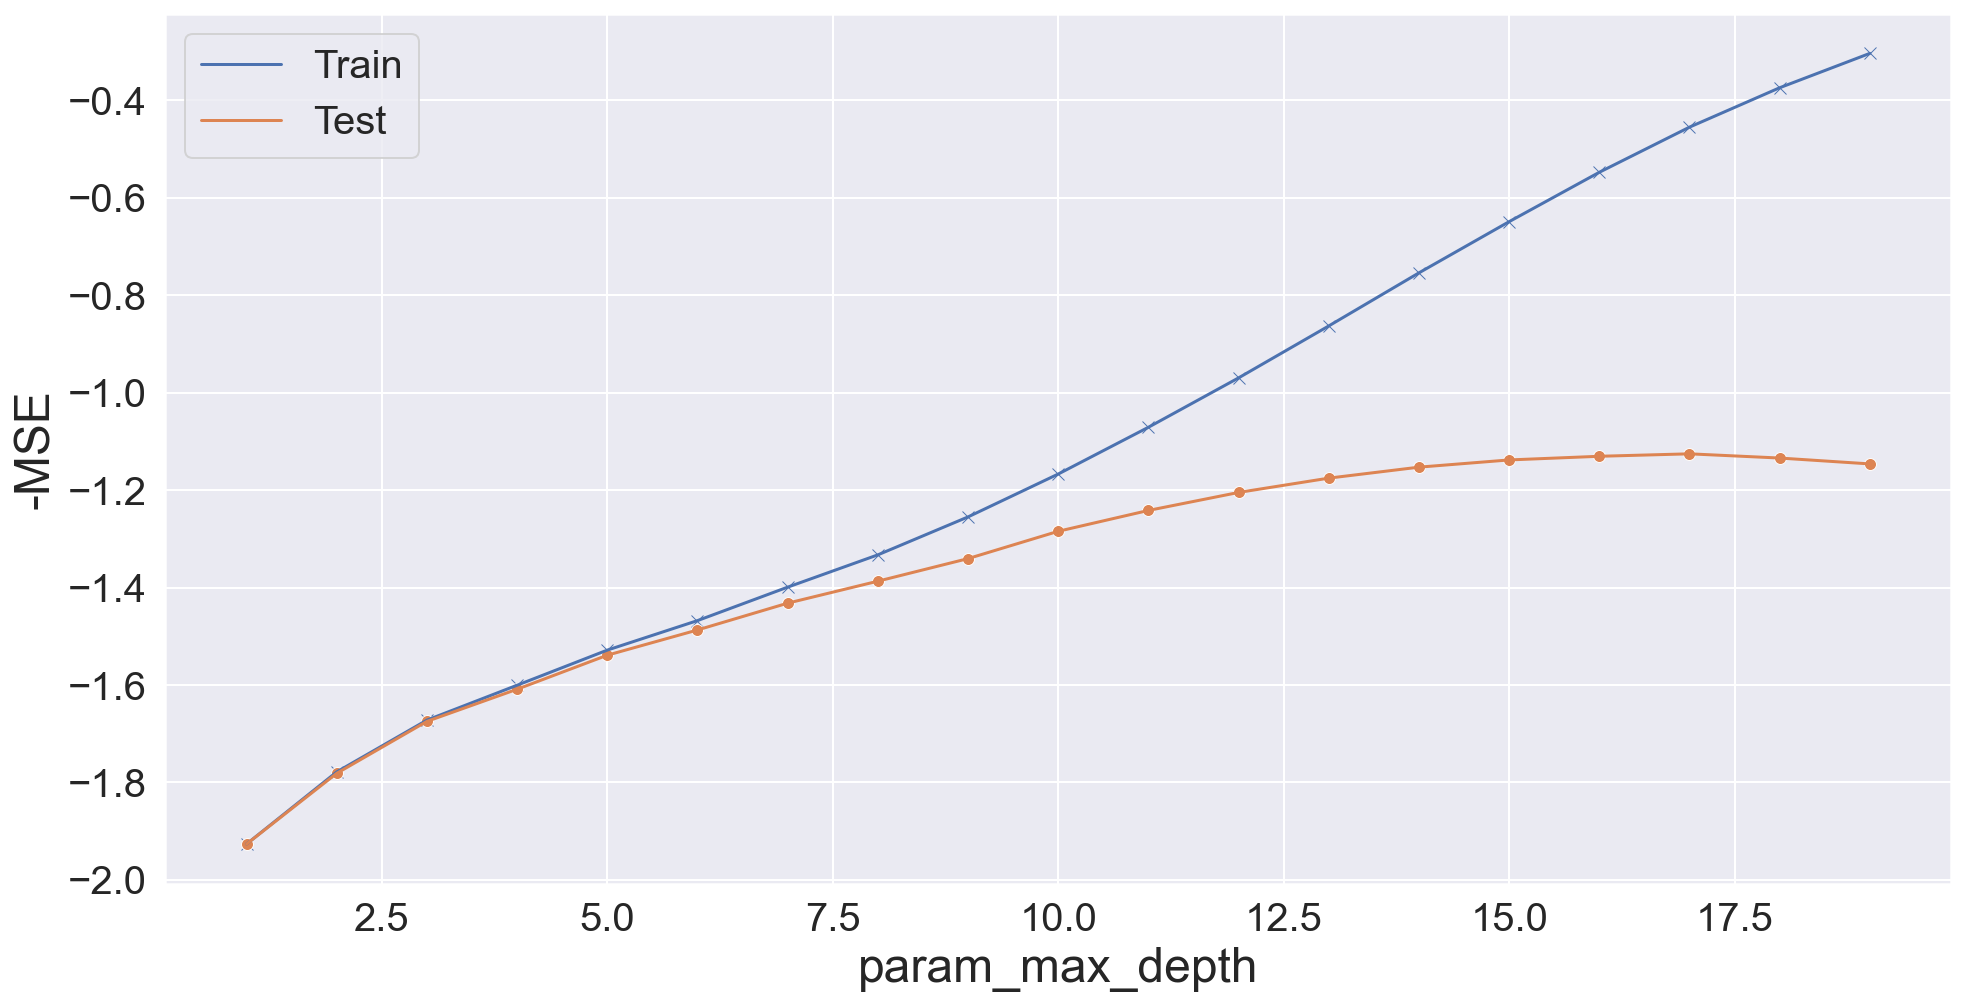

In [26]:
decision_tree = DecisionTreeRegressor(random_state=0)
gs = GridSearchCV(
    decision_tree,
    param_grid={"max_depth": range(1, 20)},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("-MSE");

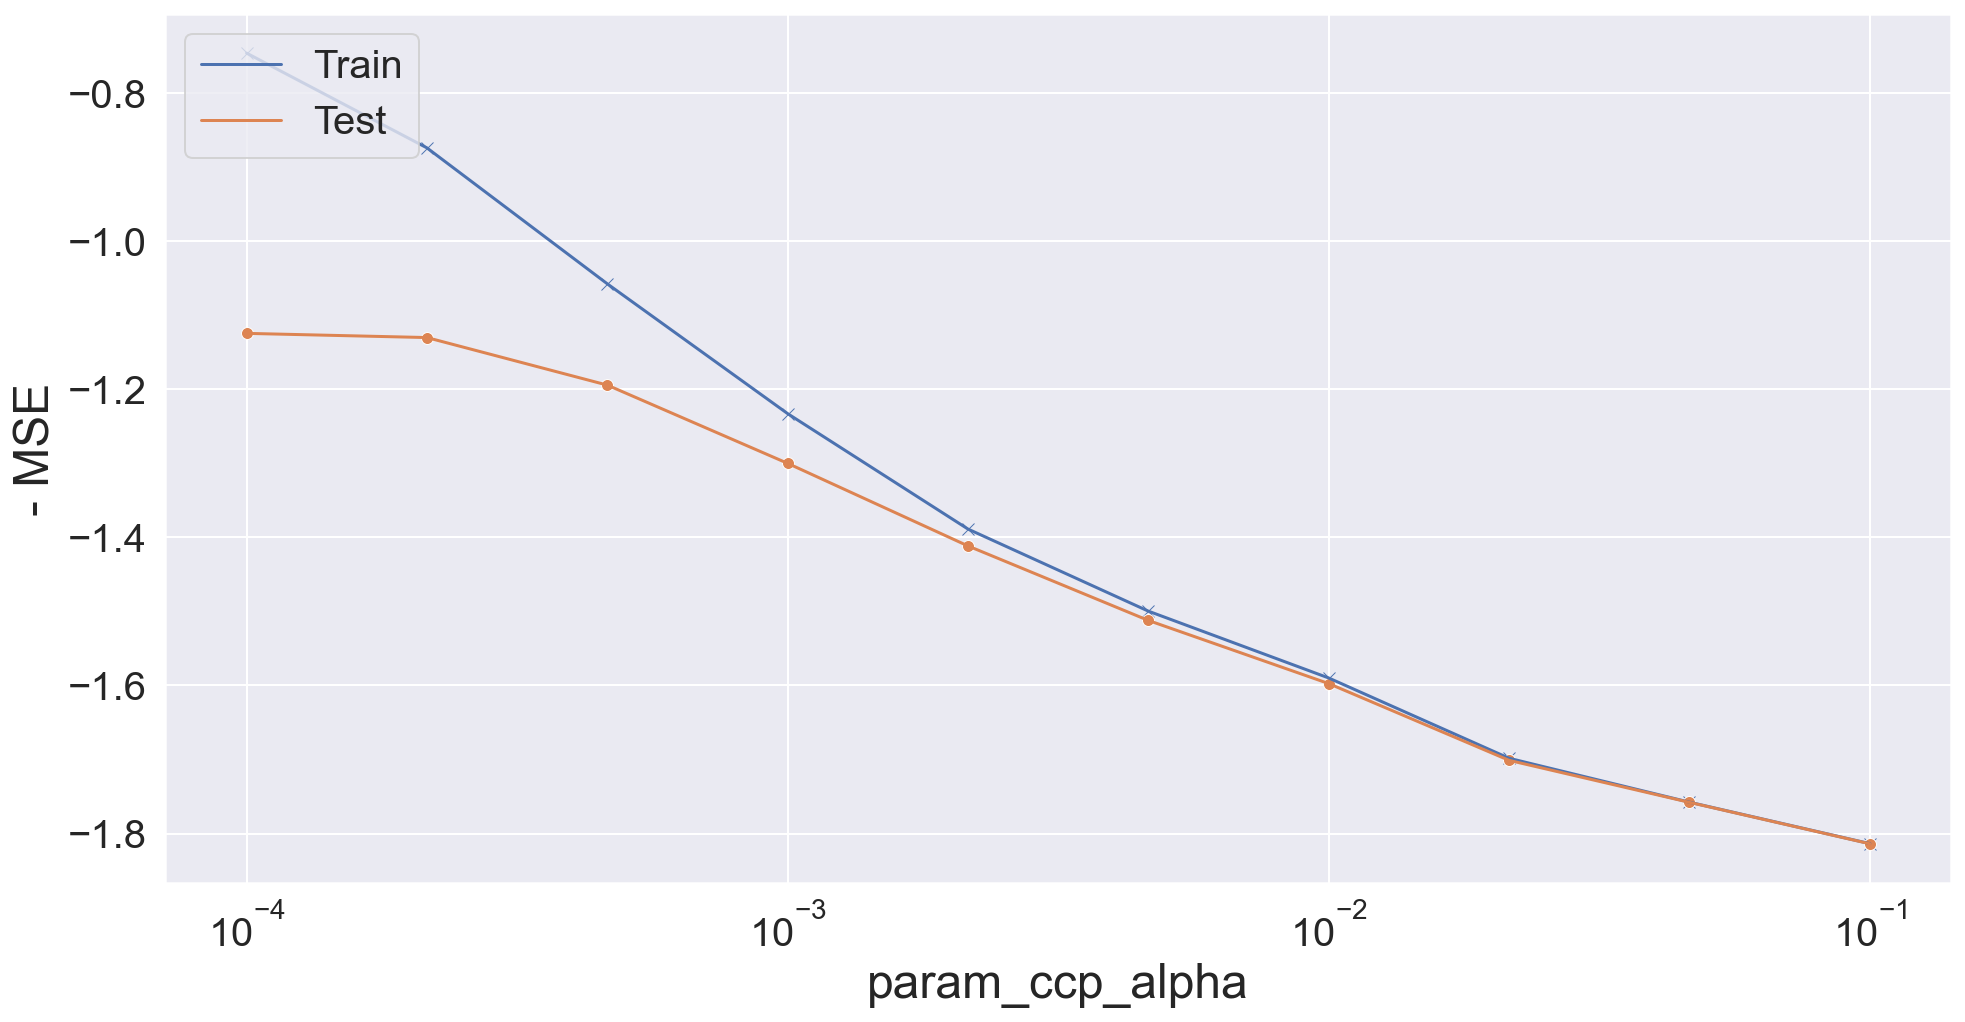

In [27]:

decision_tree = DecisionTreeRegressor(criterion="mse", random_state=0, max_depth=15)

gs = GridSearchCV(
    decision_tree,
    param_grid={"ccp_alpha": np.logspace(-4, -1, 10)},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("- MSE")
plt.xscale('log');

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y_reg, test_size=0.2)

decision_tree = DecisionTreeRegressor(criterion="mse", random_state=0, max_depth=15, ccp_alpha=0.01)
decision_tree.fit(x_train, y_train)
y_pred = decision_tree.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r = export_text(decision_tree, feature_names=list(x.columns))
print("MSE = %.3f" % (mse))
print(r)

MSE = 1.607
|--- ElectronegativityMean <= 2.24
|   |--- RowMean <= 2.24
|   |   |--- value: [2.41]
|   |--- RowMean >  2.24
|   |   |--- ElectronegativityMean <= 1.95
|   |   |   |--- value: [0.11]
|   |   |--- ElectronegativityMean >  1.95
|   |   |   |--- ColumnMin <= 2.50
|   |   |   |   |--- value: [1.27]
|   |   |   |--- ColumnMin >  2.50
|   |   |   |   |--- value: [0.45]
|--- ElectronegativityMean >  2.24
|   |--- AtomicWeightMean <= 20.42
|   |   |--- AtomicRadiusMax <= 2.57
|   |   |   |--- value: [3.65]
|   |   |--- AtomicRadiusMax >  2.57
|   |   |   |--- AtomicWeightMean <= 16.62
|   |   |   |   |--- value: [3.04]
|   |   |   |--- AtomicWeightMean >  16.62
|   |   |   |   |--- value: [2.06]
|   |--- AtomicWeightMean >  20.42
|   |   |--- ColumnMin <= 3.50
|   |   |   |--- ElectronegativityMean <= 2.71
|   |   |   |   |--- AtomicRadiusMin <= 1.18
|   |   |   |   |   |--- value: [2.32]
|   |   |   |   |--- AtomicRadiusMin >  1.18
|   |   |   |   |   |--- value: [1.35]
|   |  

In [29]:
# Ensemble Learning

In [30]:
max_depth_class = 3
max_depth_reg = 15

In [31]:
# Adaboost

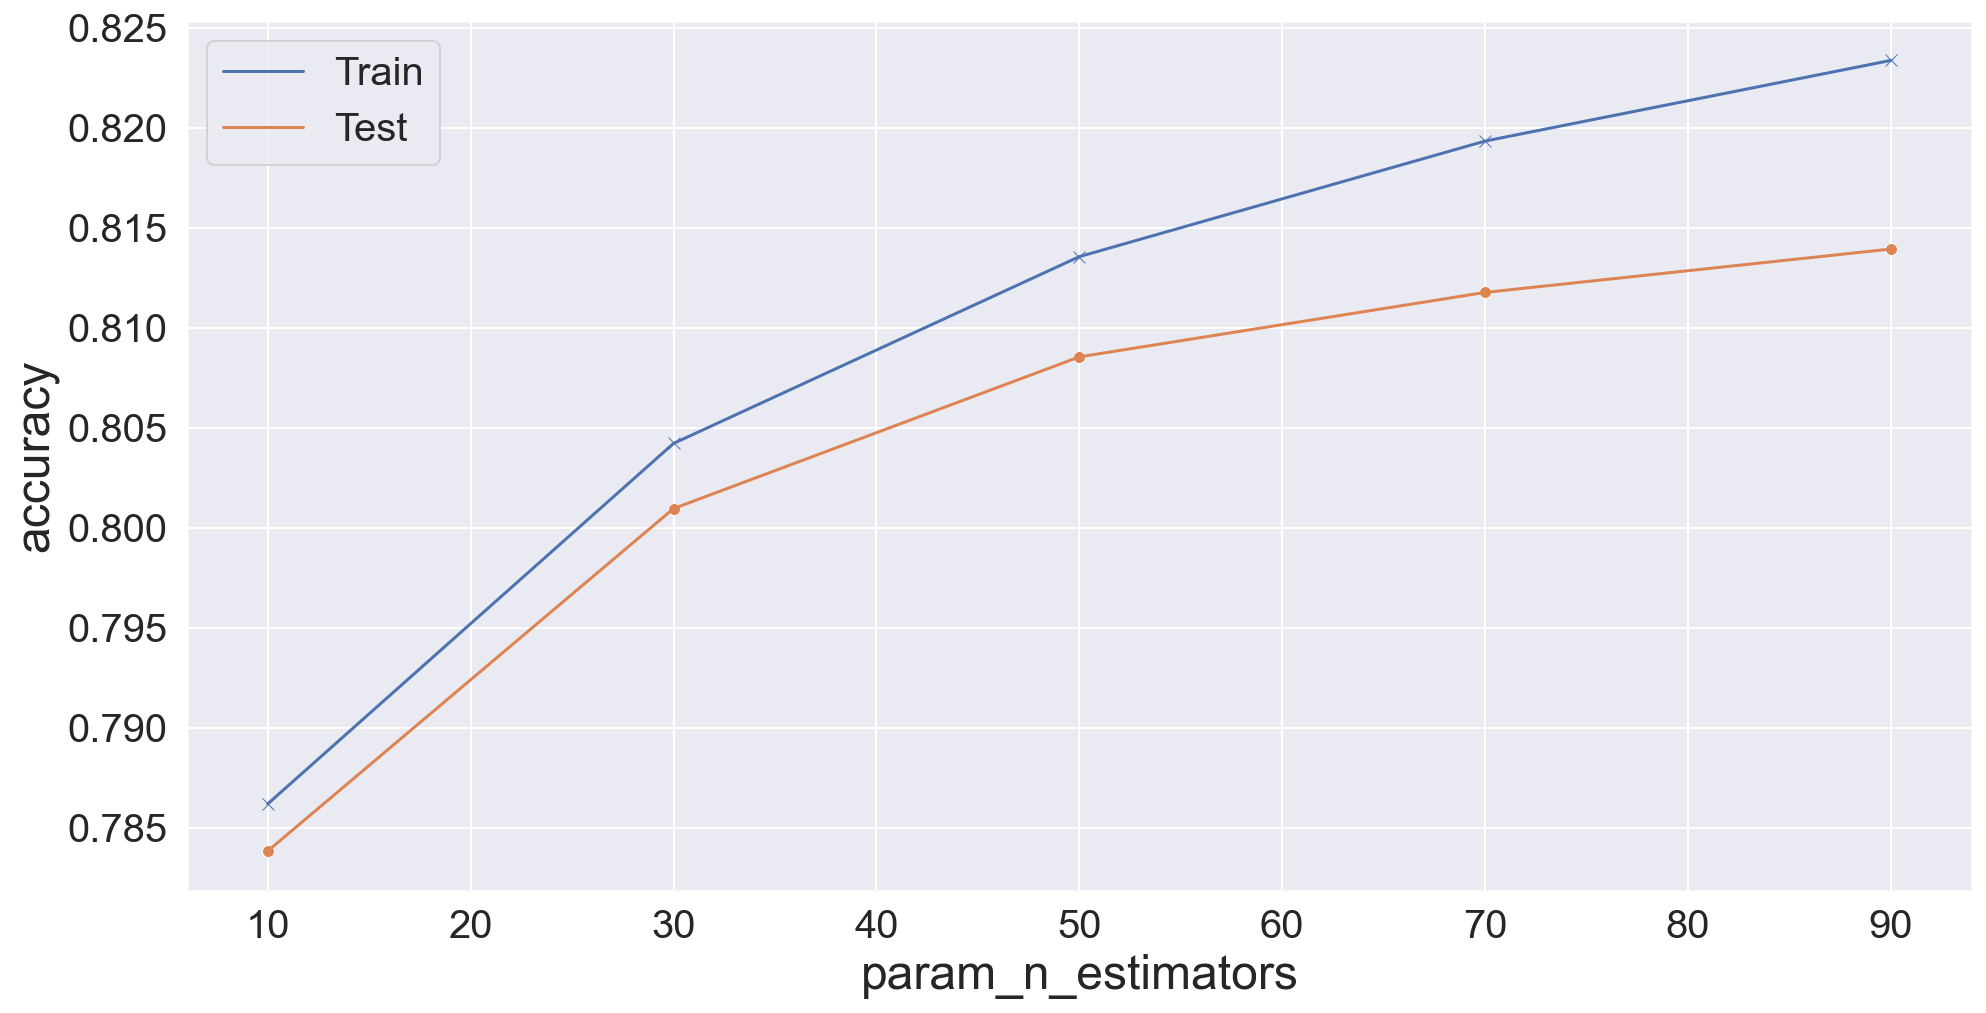

In [32]:
model = AdaBoostClassifier(DecisionTreeClassifier(random_state=0, max_depth=max_depth_class))

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": range(10, 100, 20)},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy");

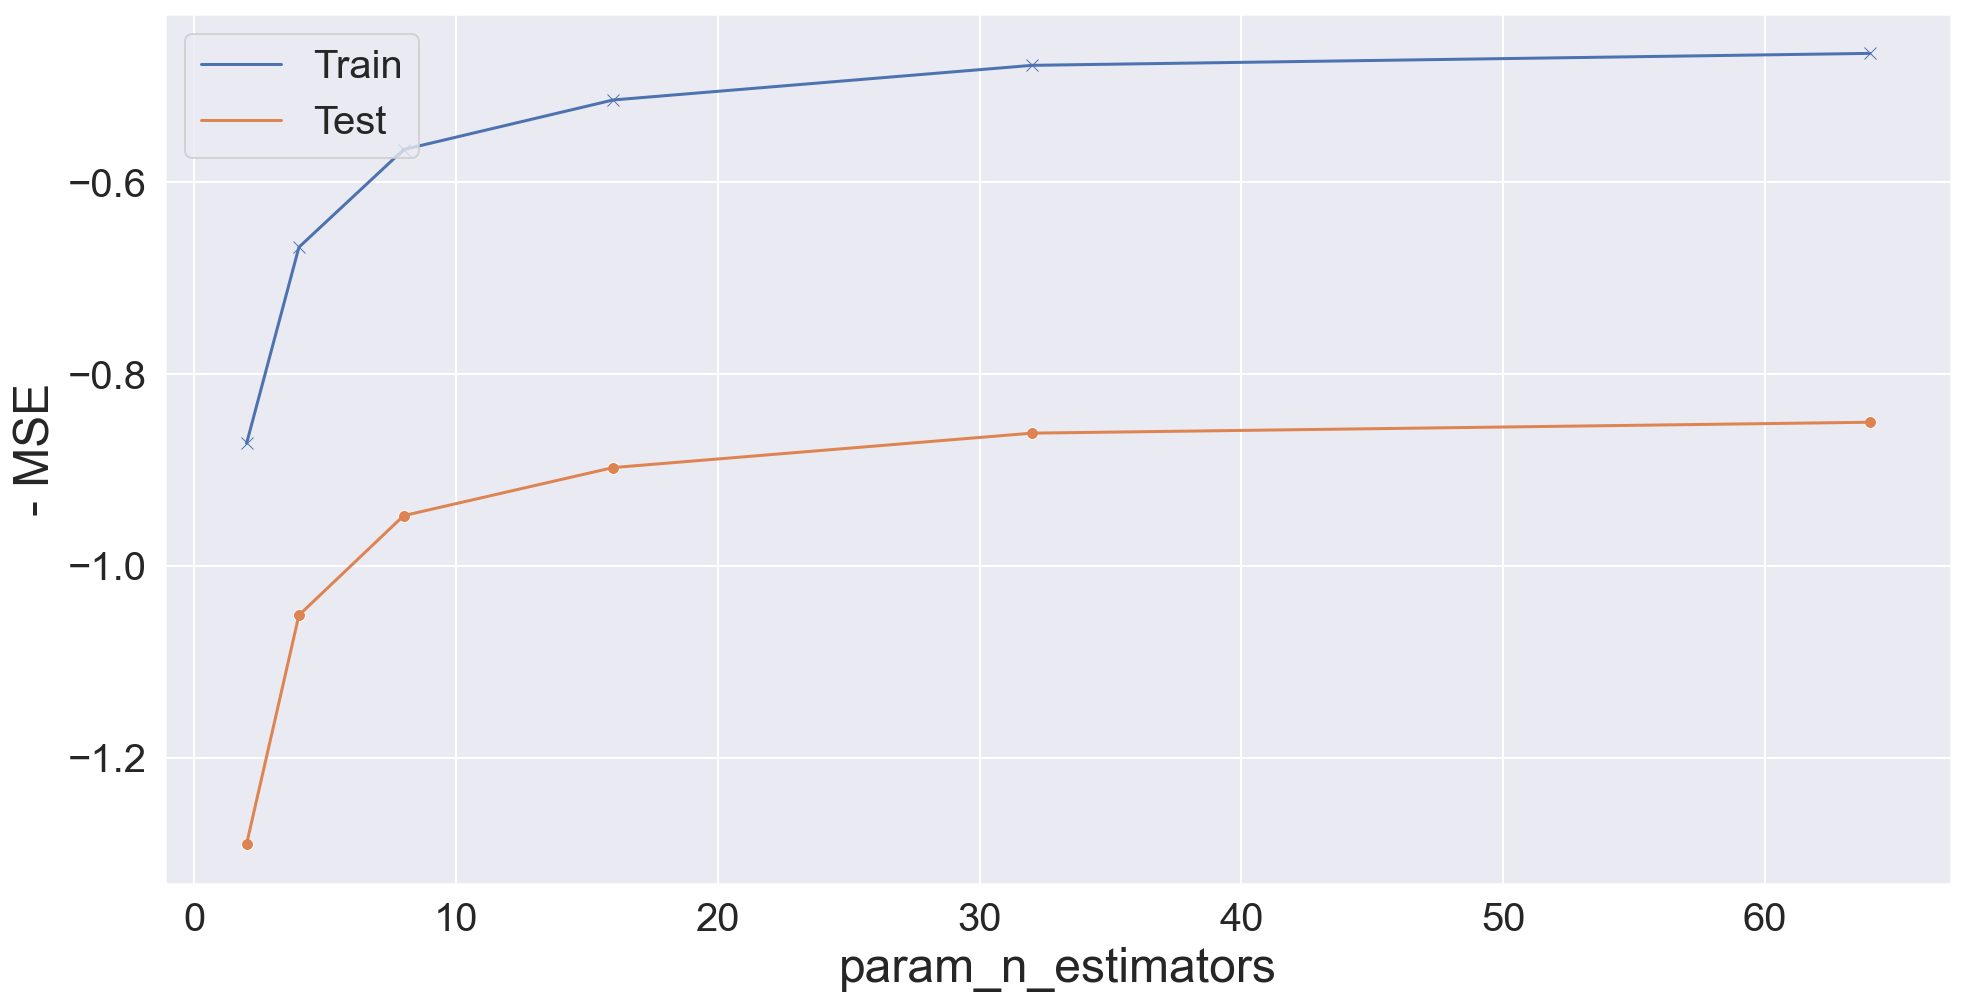

In [33]:
model = AdaBoostRegressor(DecisionTreeRegressor(random_state=0, max_depth=max_depth_reg), 
                          learning_rate=0.1)

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": [2, 4, 8, 16, 32, 64]},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("- MSE");

In [34]:
# Gradient boosting

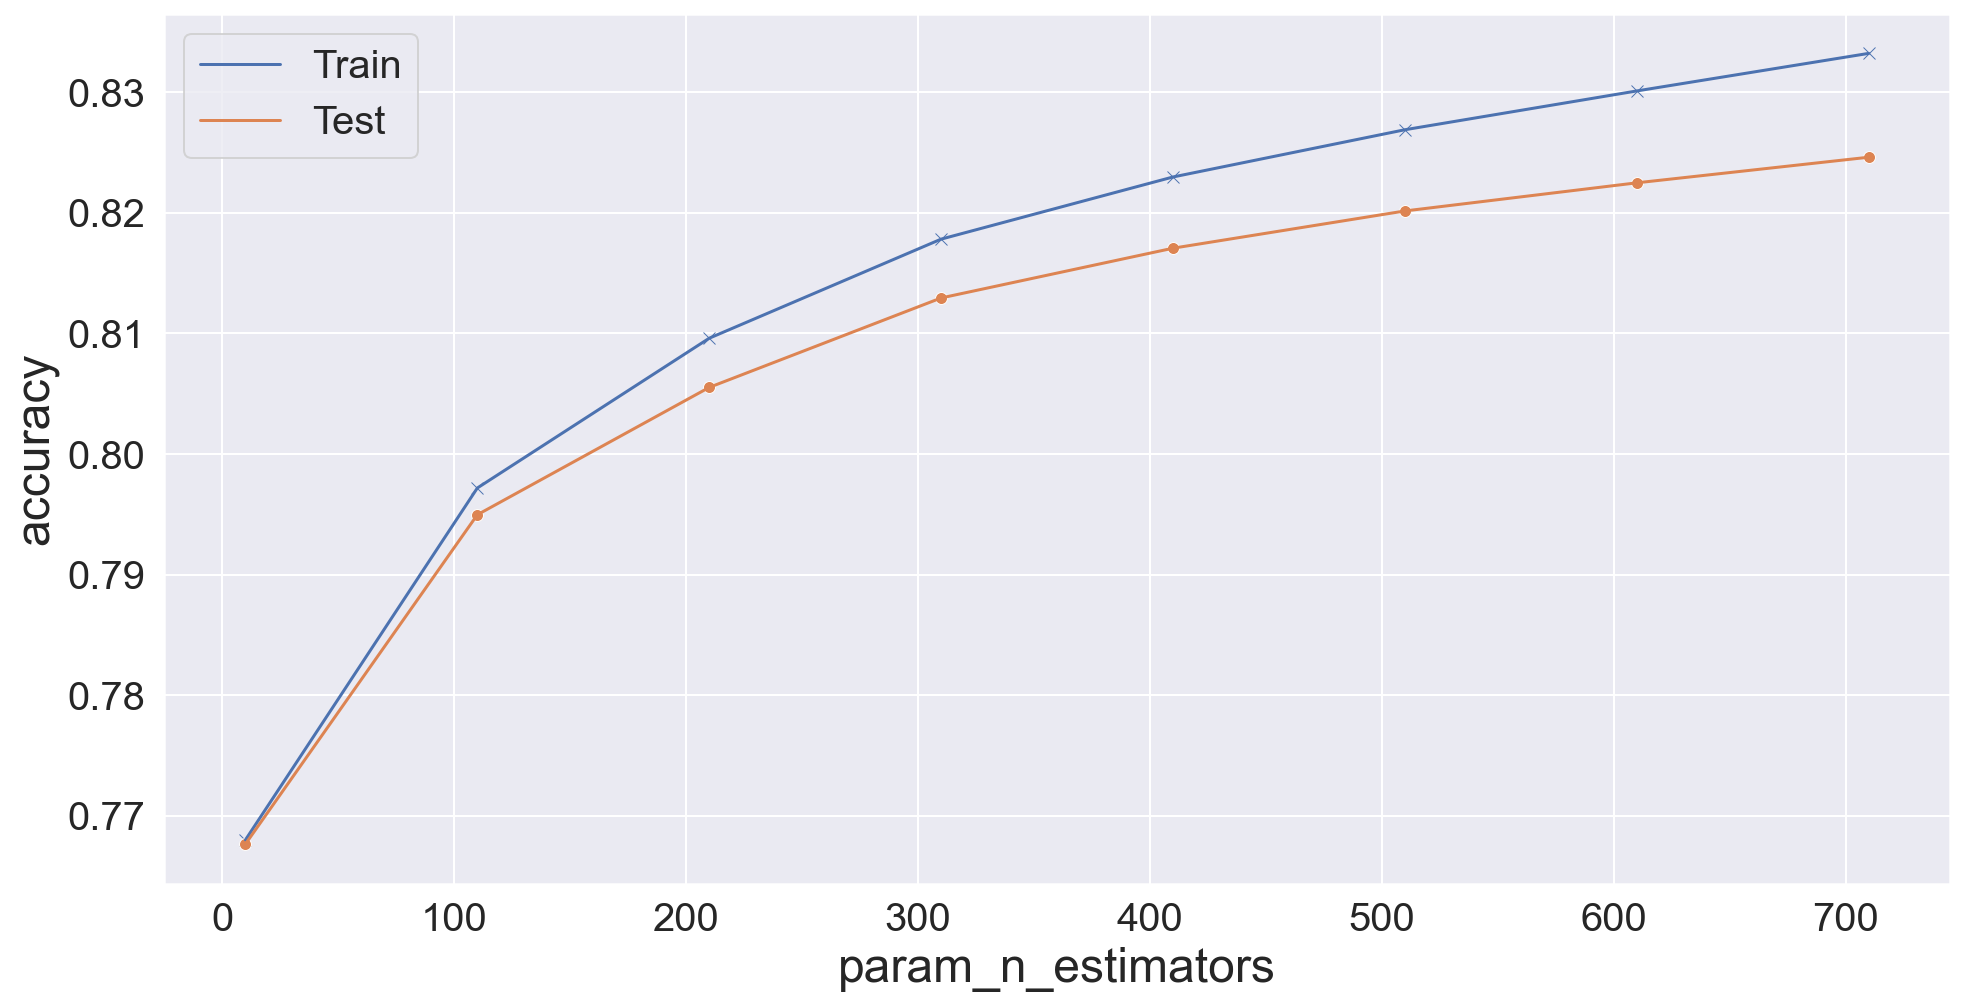

In [35]:
model = GradientBoostingClassifier(random_state=0, max_depth=max_depth_class)

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": range(10, 800, 100)},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold,
    n_jobs=4
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy");

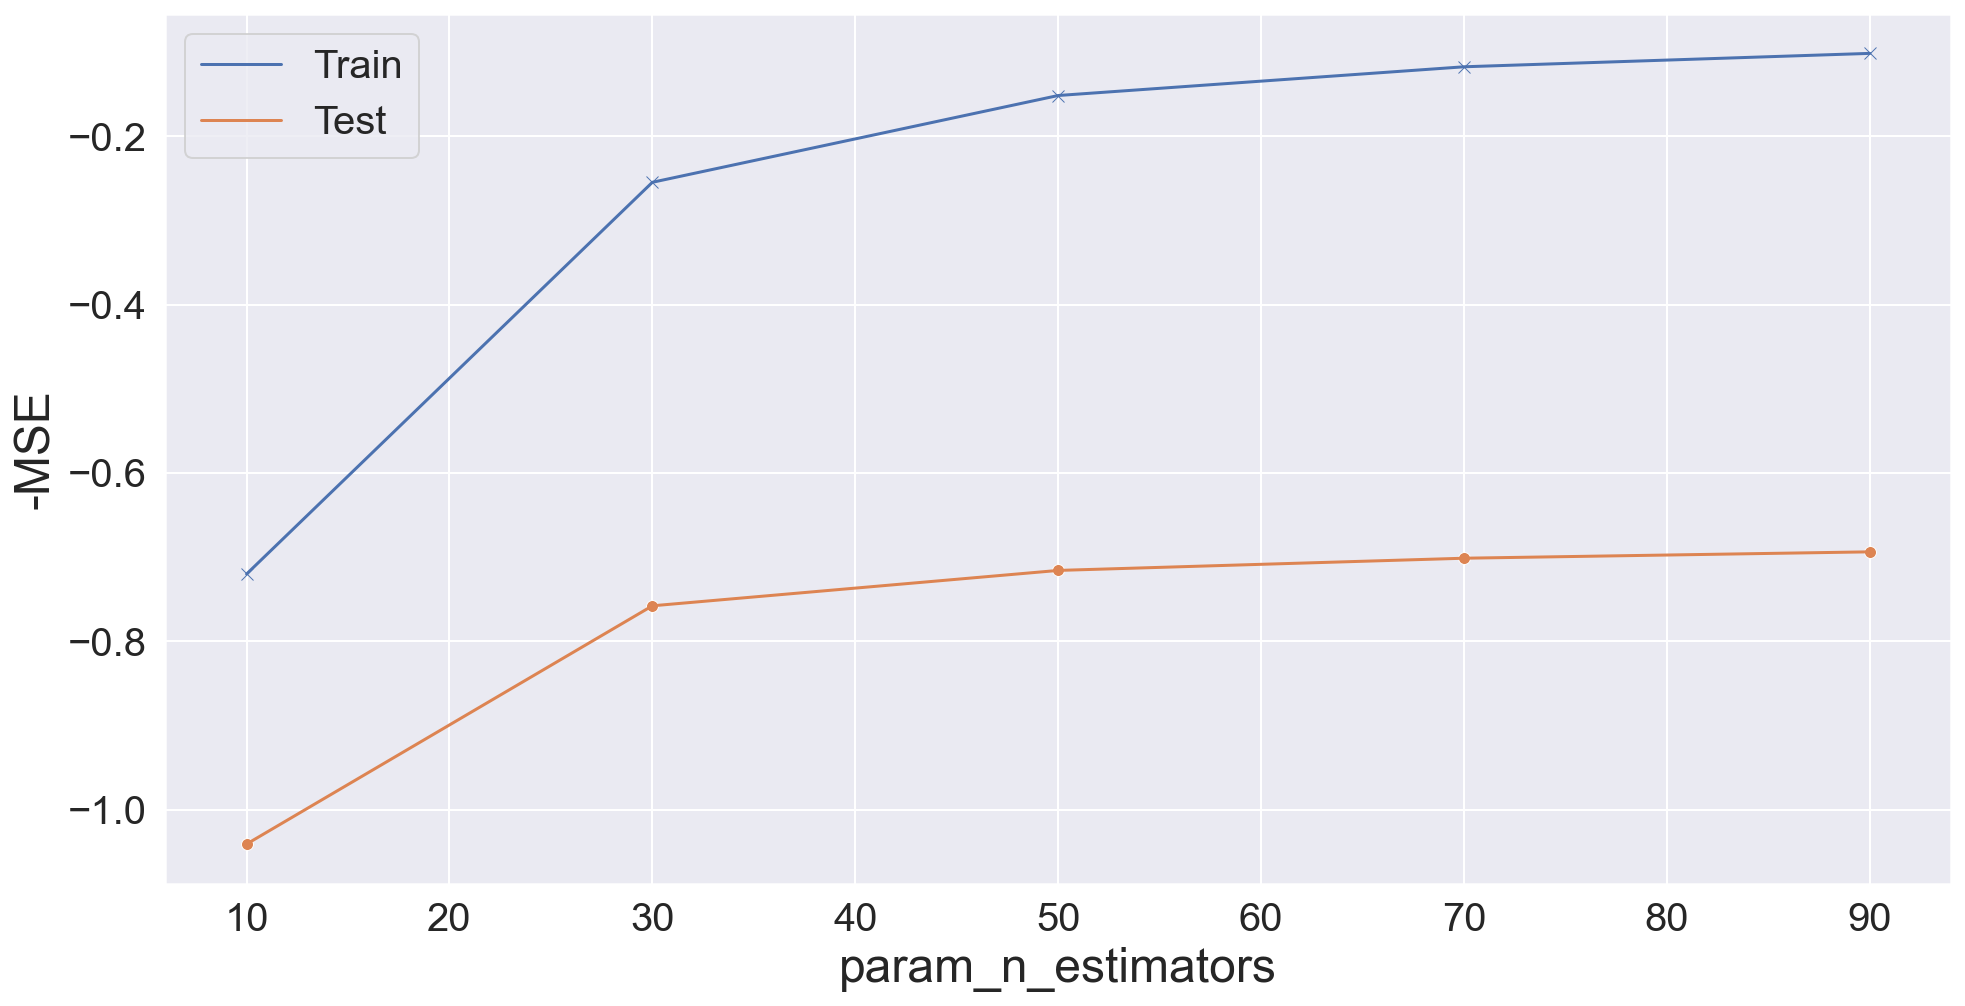

In [36]:

model = GradientBoostingRegressor(random_state=0, max_depth=max_depth_reg)

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": range(10, 100, 20)},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold,
    n_jobs=4
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("-MSE");

In [37]:
# Random Forests

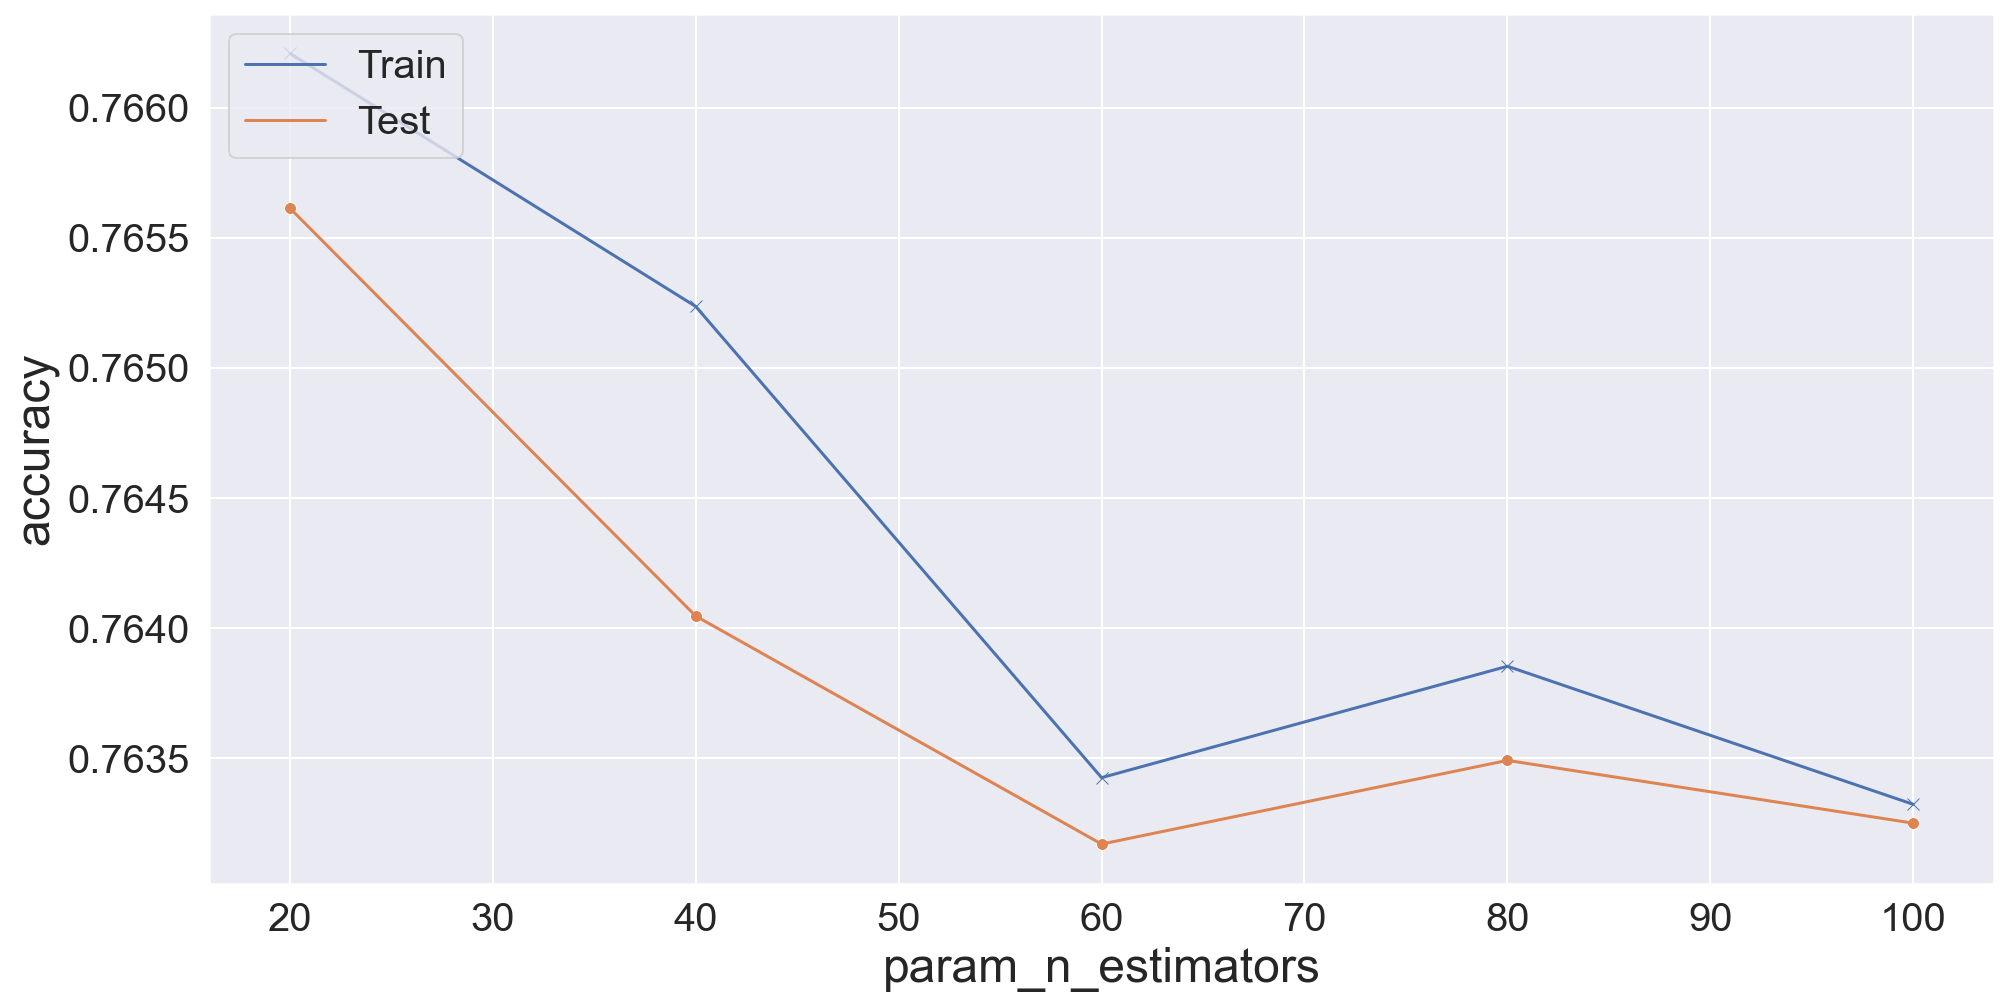

In [38]:
model = RandomForestClassifier(random_state=0, max_depth=max_depth_class)

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": range(20, 120, 20)},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold,
    n_jobs=4
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy");

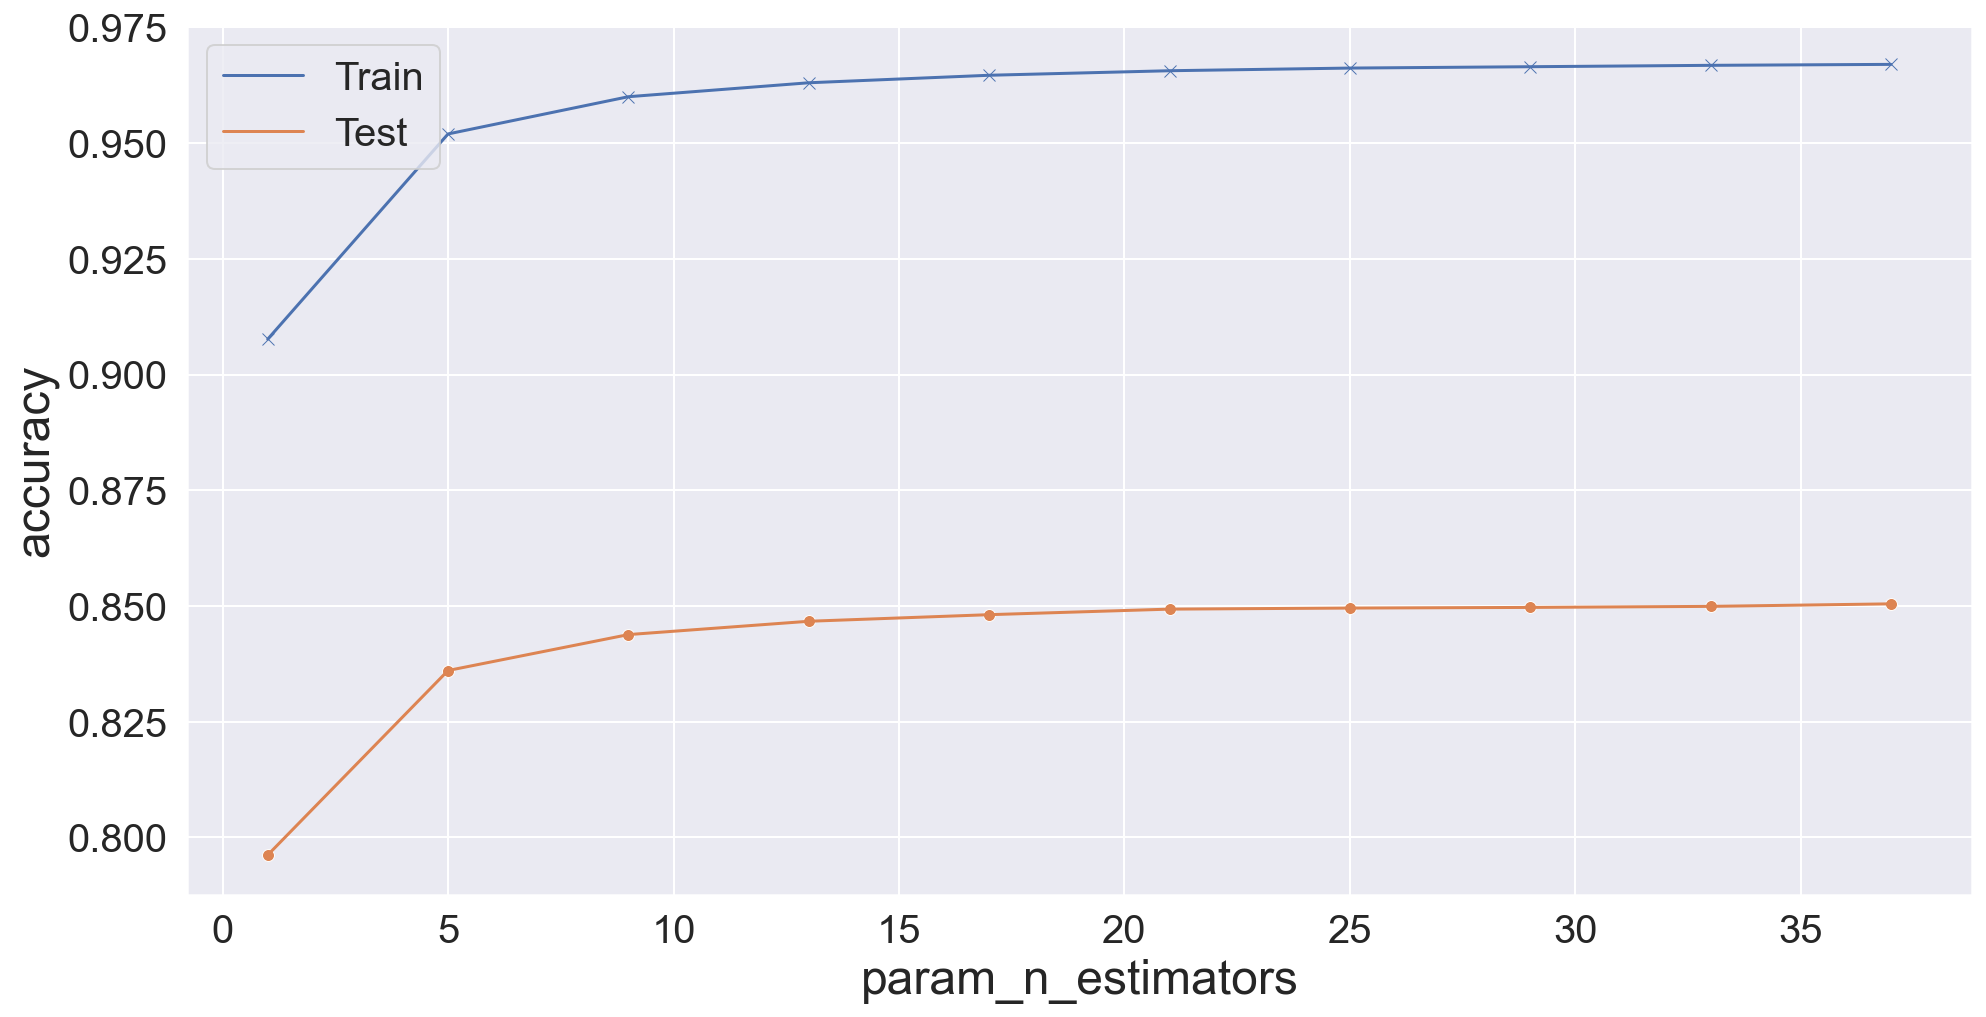

In [39]:
model = RandomForestClassifier(random_state=0)

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": range(1, 40, 4)},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold,
    n_jobs=4
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy");

C:\Users\YoYo\miniconda3\envs\nano281\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


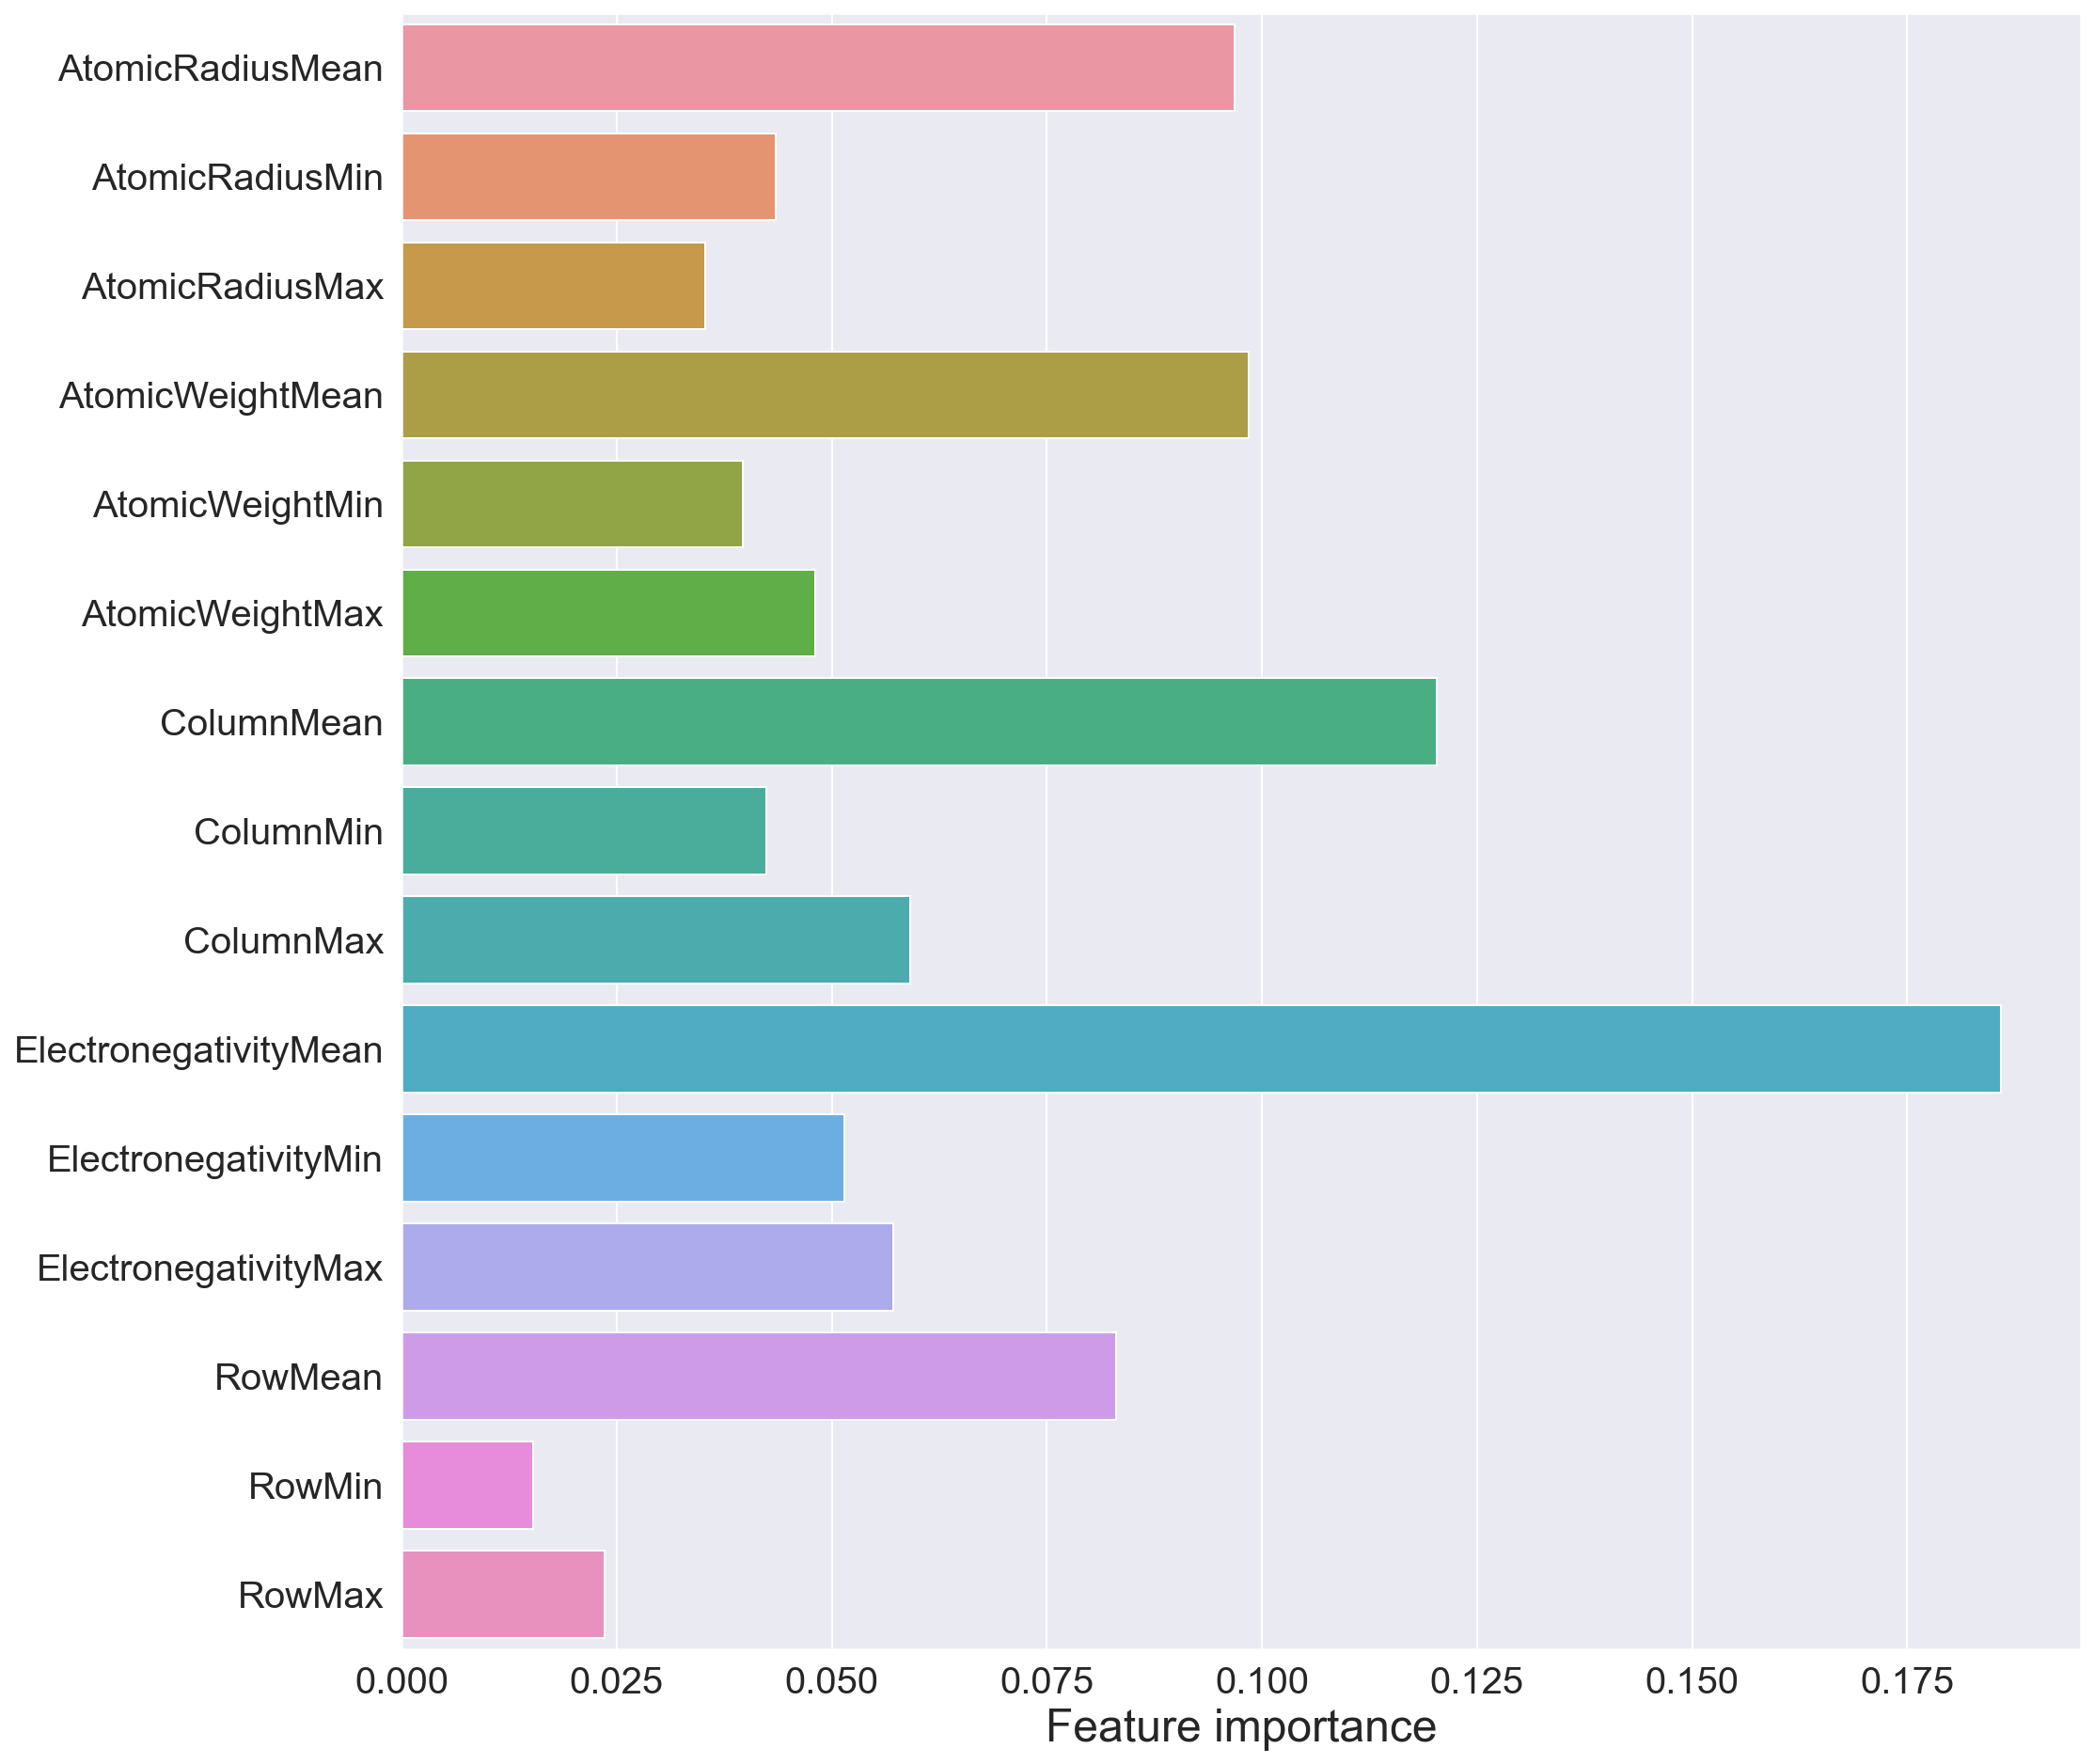

In [40]:
model = RandomForestClassifier(random_state=0, n_estimators=20)
model.fit(x, y_class)
plt.subplots(figsize=(16, 16))
sns.barplot(model.feature_importances_, list(x.columns), orient='h')
plt.xlabel("Feature importance");

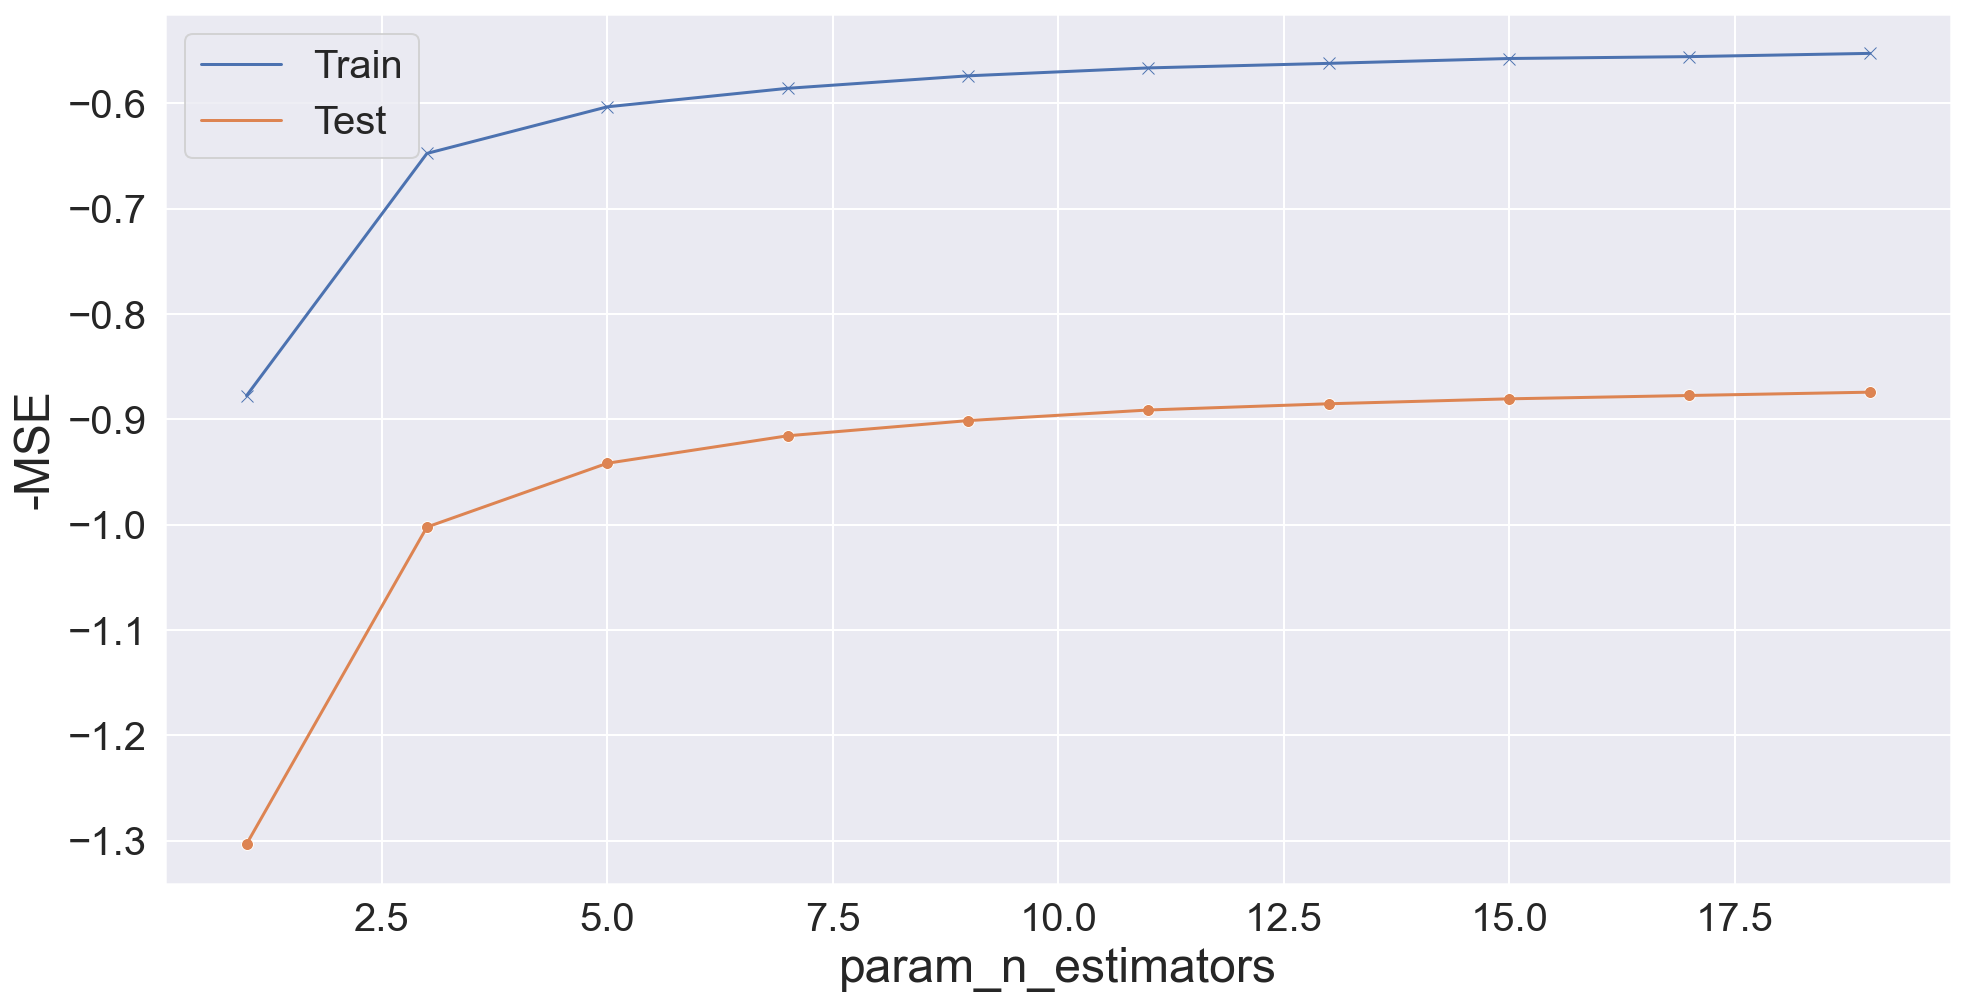

In [41]:

model = RandomForestRegressor(random_state=0, max_depth=max_depth_reg)

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": range(1, 20, 2)},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold,
    n_jobs=8
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("-MSE");

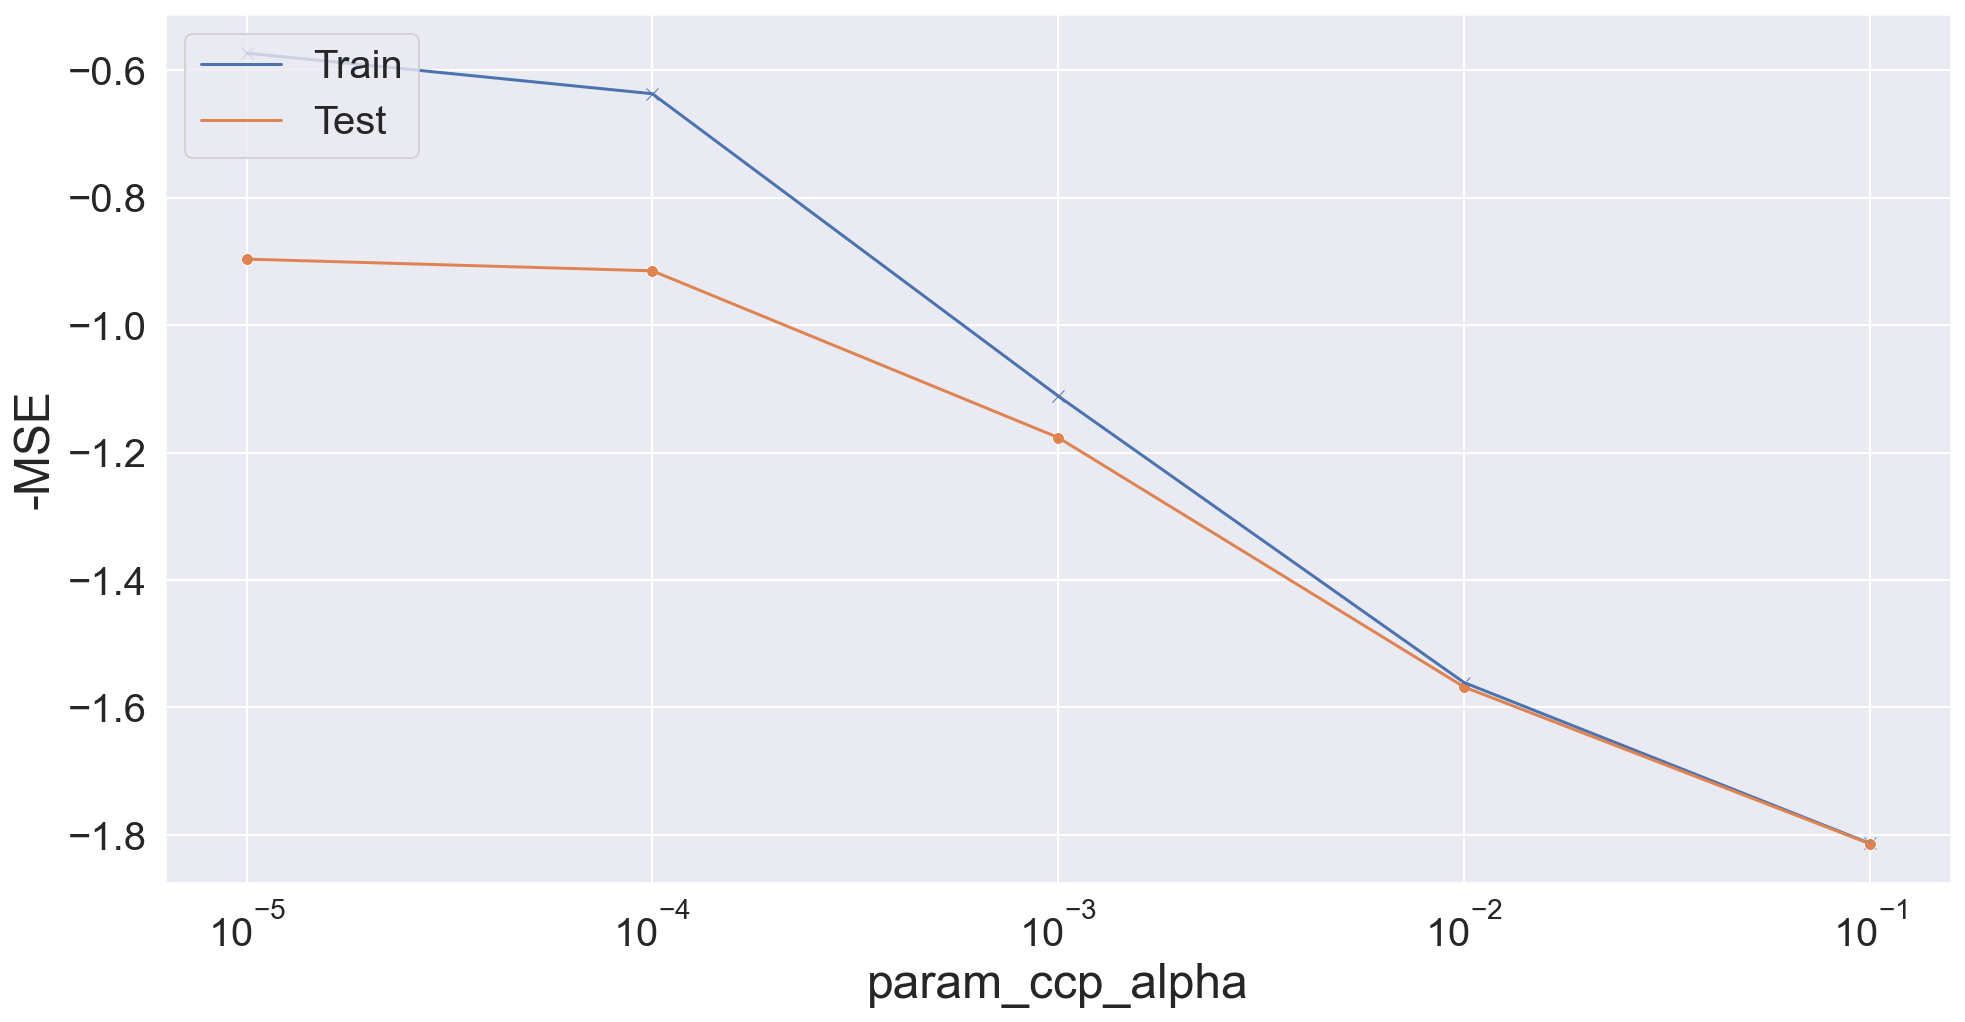

In [42]:

model = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=10)

gs = GridSearchCV(
    model,
    param_grid={"ccp_alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold,
    n_jobs=8
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("-MSE");
plt.xscale('log')